In [1]:
#Librerías para manejo de datos
import pandas as pd
import numpy as np

#Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelar
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedGroupKFold, StratifiedKFold, KFold,RandomizedSearchCV, RepeatedKFold, GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score, make_scorer, classification_report
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

#Librería para tendencia al cluster
from pyclustertend import hopkins
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

#Librerías para visualización de barrios
import geopandas as gp
from seaborn import color_palette
import matplotlib.colors as colors

#grafico del arbol
from six import StringIO
from IPython.display import Image  
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree #,export_graphviz
import sklearn as sk

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
import multiprocessing

from sklearn.svm import SVC

In [2]:
import matplotlib                                #  ESTO ARREGLA EL ERROR
from matplotlib import rcParams, rcParamsDefault #  findfont: Generic family 'sans-serif' not found because none of the following families were found: 
rcParams.update(rcParamsDefault)                 #  BORRAR UNA VEZ SEGUROS QUE YA NO PASE

# Ejercicio 3

## Construccion del target

Para esta tarea se debe crear una nueva variable tipo_precio que tendrá tres categorías: alto, medio, bajo. Esta nueva variable será nuestra clase en el problema de clasificación.
Para determinar cuándo el tipo_precio de una propiedad es alto, medio o bajo se deberá analizar el precio por metro cuadrado (pxm2). Se propone evaluar las siguientes alternativas para establecer los límites de cada categoría.

In [3]:
df_tprecio = pd.read_csv('./data/properati_argentina_2021_filtrado.csv')
df_tprecio['pxm2'] = round(df_tprecio["property_price"] / df_tprecio['property_surface_total'], 0)
df_tprecio

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82502 -34.603245 -58.489810      Villa del Parque  Departamento   
82503 -34.614063 -58.482814      Villa del Parque  Departamento   
82504 -34.614175 -58.479062      Villa del Parque  Departamento   
82505 -34.614175 -58.479062      Villa del Parque  Departamento   
82506 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82502               4                  3              130.000000   
82503               3                  2               68.000000   
82504               1                  1               51.000000   
82505               1                  1               37.000000   
82506               2                  1               84.000000   

       property_surface_covered  property_price    pxm2  
0                         133.0        210000.0  1228.0  
1                          55.0         82900.0  1429.0  
2                          70.0         99000.0  1414.0  
3                         104.0        146000.0  1079.0  
4                          73.0        250000.0  2349.0  
...                         ...             ...     ...  
82502                     100.0        220000.0  1692.0  
82503                      60.0        161000.0  2368.0  
82504                      30.0         75500.0  1480.0  
82505                      31.0         74500.0  2014.0  
82506                      84.0        135000.0  1607.0  

[82507 rows x 10 columns]

Buscamos posibles outliers en el nuevo atributo creado

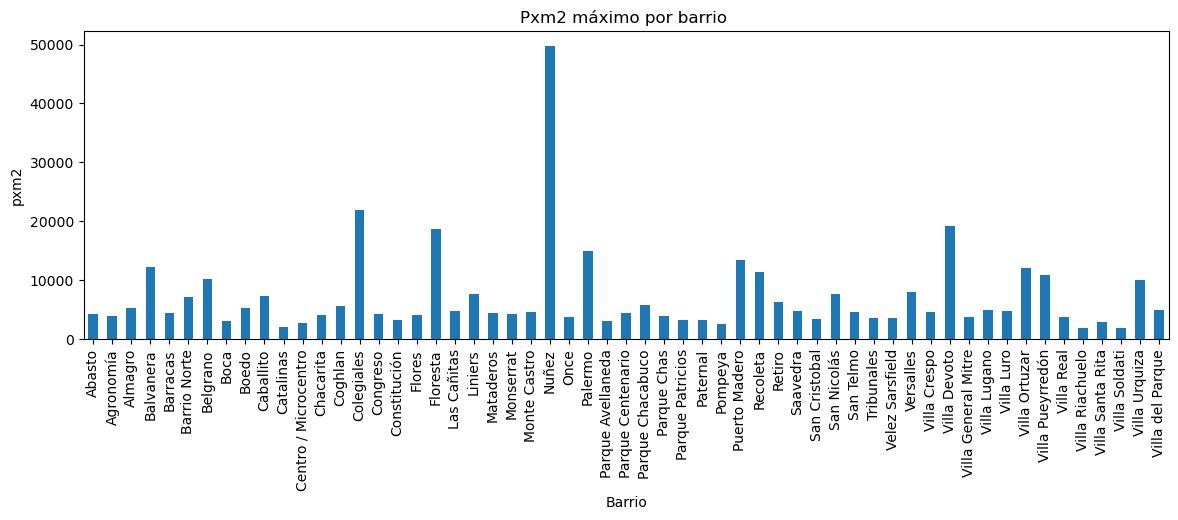

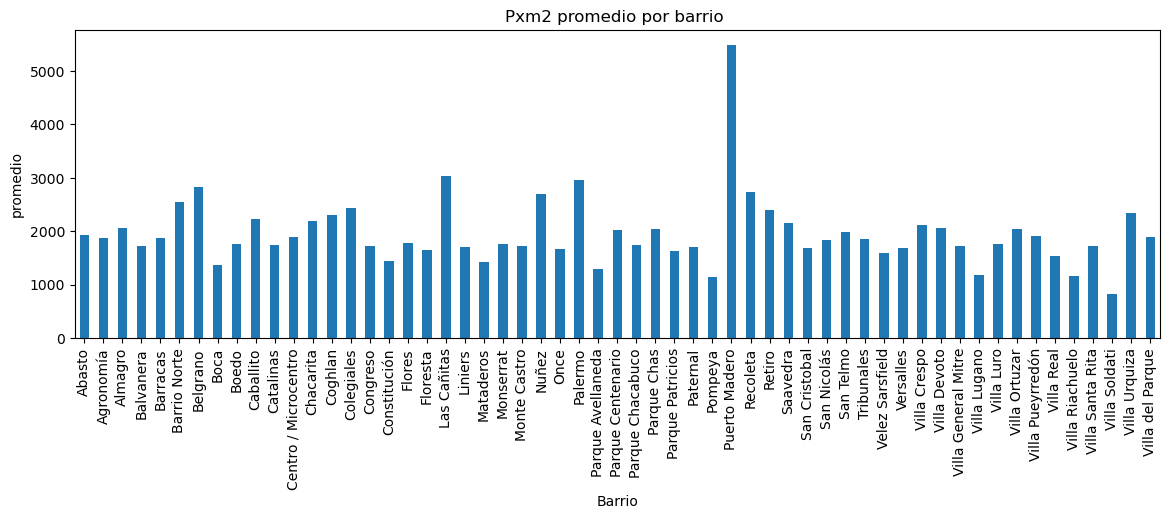

In [4]:
plt.rcParams['figure.figsize'] = (14,4)
df_tprecio.groupby(by=['place_l3'])['pxm2'].max().plot.bar(alpha=1 , title="Pxm2 máximo por barrio " , xlabel="Barrio" , ylabel="pxm2")
plt.show()

promedios_por_barrio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean()
promedios_por_barrio.plot.bar(alpha=1 , title="Pxm2 promedio por barrio " , xlabel="Barrio" , ylabel="promedio")
plt.show()

Si bien el promedio se ve bien, notamos la precencia de varios outliers. Procedemos a normalizar los valores de pxm2 para asi eliminar los outliers.

In [5]:
# Este max_pxm2_promedio va a ser el valor de arriba de Puerto Madero
max_pxm2_promedio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean().max();
promedios_por_barrio_dict = promedios_por_barrio.to_dict()
promedios_por_barrio_dict

{'Abasto': 1926.9064039408868,
 'Agronomía': 1873.762331838565,
 'Almagro': 2059.9690837549183,
 'Balvanera': 1719.70536883457,
 'Barracas': 1864.9838565022421,
 'Barrio Norte': 2540.142416055577,
 'Belgrano': 2829.722477365175,
 'Boca': 1374.5295857988165,
 'Boedo': 1765.2069868995634,
 'Caballito': 2231.0872941907423,
 'Catalinas': 1743.2857142857142,
 'Centro / Microcentro': 1894.9714285714285,
 'Chacarita': 2186.8810289389066,
 'Coghlan': 2294.584841628959,
 'Colegiales': 2437.3306074766356,
 'Congreso': 1721.155069582505,
 'Constitución': 1436.0171149144255,
 'Flores': 1771.480633802817,
 'Floresta': 1652.397424103036,
 'Las Cañitas': 3039.5384615384614,
 'Liniers': 1703.462311557789,
 'Mataderos': 1427.2005943536403,
 'Monserrat': 1763.679435483871,
 'Monte Castro': 1725.2820512820513,
 'Nuñez': 2691.807667525773,
 'Once': 1670.8147368421053,
 'Palermo': 2963.2752384084183,
 'Parque Avellaneda': 1289.215258855586,
 'Parque Centenario': 2027.108695652174,
 'Parque Chacabuco': 1745

In [6]:
def corregir_pxm2(pxm2, place):
    return pxm2 if pxm2 < max_pxm2_promedio else round(promedios_por_barrio_dict[place], 0)

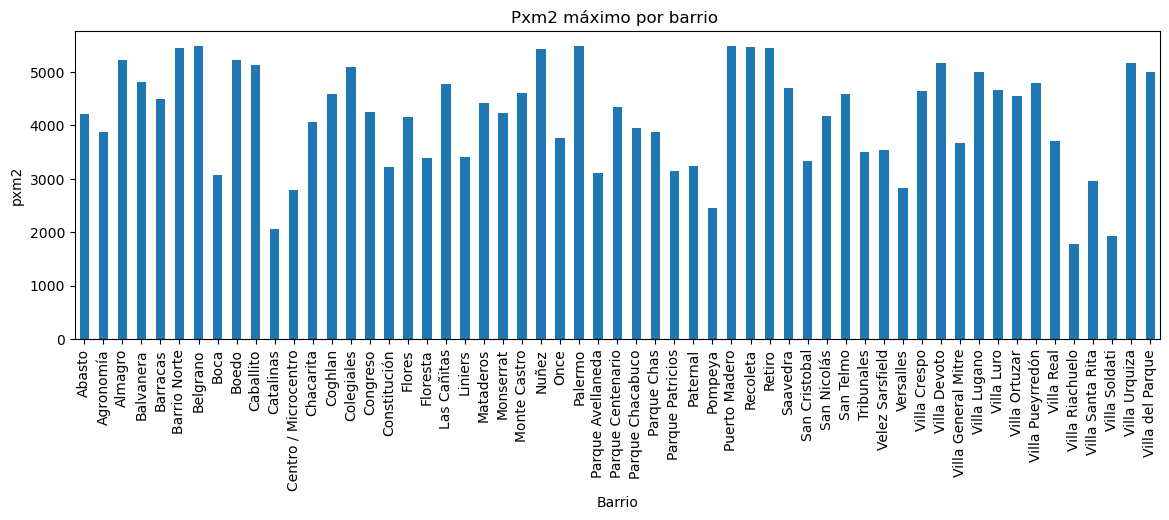

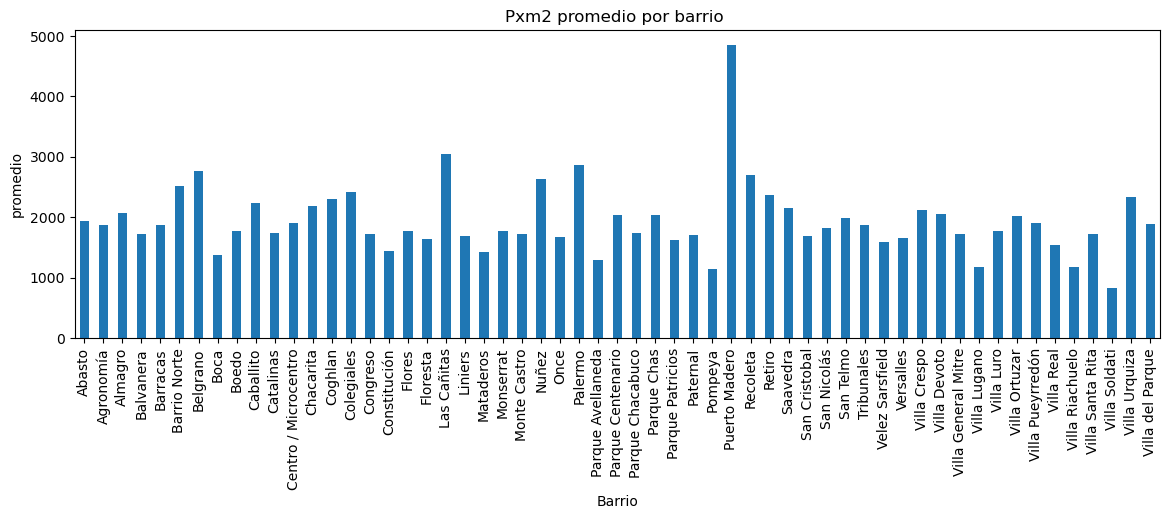

In [7]:
df_tprecio['pxm2'] = df_tprecio.apply(lambda row: corregir_pxm2(row['pxm2'], row['place_l3']), axis=1)

# Verificamos que los máximos de cada barrio estén más normalizados

plt.rcParams['figure.figsize'] = (14,4)
df_tprecio.groupby(by=['place_l3'])['pxm2'].max().plot.bar(alpha=1 , title="Pxm2 máximo por barrio " , xlabel="Barrio" , ylabel="pxm2")
plt.show()

promedios_por_barrio = df_tprecio.groupby(by=['place_l3'])['pxm2'].mean()
promedios_por_barrio.plot.bar(alpha=1 , title="Pxm2 promedio por barrio " , xlabel="Barrio" , ylabel="promedio")
plt.show()

### Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

In [8]:
df_tprecio1 = df_tprecio.copy()

In [9]:
df_tprecio1["tipo_precio"] = pd.qcut( df_tprecio1["pxm2"],
                            q=3, # Separo en tres categorias iguales
                            labels=["bajo", "medio", "alto"])

df_tprecio1

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82502 -34.603245 -58.489810      Villa del Parque  Departamento   
82503 -34.614063 -58.482814      Villa del Parque  Departamento   
82504 -34.614175 -58.479062      Villa del Parque  Departamento   
82505 -34.614175 -58.479062      Villa del Parque  Departamento   
82506 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82502               4                  3              130.000000   
82503               3                  2               68.000000   
82504               1                  1               51.000000   
82505               1                  1               37.000000   
82506               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0        bajo  
1                          55.0         82900.0  1429.0        bajo  
2                          70.0         99000.0  1414.0        bajo  
3                         104.0        146000.0  1079.0        bajo  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82502                     100.0        220000.0  1692.0        bajo  
82503                      60.0        161000.0  2368.0       medio  
82504                      30.0         75500.0  1480.0        bajo  
82505                      31.0         74500.0  2014.0       medio  
82506                      84.0        135000.0  1607.0        bajo  

[82507 rows x 11 columns]

Verifico que se haya separado (aproximadamente) en partes iguales

In [10]:
df_tprecio1["tipo_precio"].value_counts()

bajo     27536
alto     27489
medio    27482
Name: tipo_precio, dtype: int64

### Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones, el siguiente con el 50% y el ultimo con el 25% de las observaciones restantes.

In [11]:
df_tprecio2 = df_tprecio.copy()

In [12]:
df_tprecio2["tipo_precio"] = pd.qcut( df_tprecio2["pxm2"],
                            [0, .25, .75, 1],
                            labels=["bajo", "medio", "alto"])

df_tprecio2

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82502 -34.603245 -58.489810      Villa del Parque  Departamento   
82503 -34.614063 -58.482814      Villa del Parque  Departamento   
82504 -34.614175 -58.479062      Villa del Parque  Departamento   
82505 -34.614175 -58.479062      Villa del Parque  Departamento   
82506 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82502               4                  3              130.000000   
82503               3                  2               68.000000   
82504               1                  1               51.000000   
82505               1                  1               37.000000   
82506               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0        bajo  
1                          55.0         82900.0  1429.0        bajo  
2                          70.0         99000.0  1414.0        bajo  
3                         104.0        146000.0  1079.0        bajo  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82502                     100.0        220000.0  1692.0        bajo  
82503                      60.0        161000.0  2368.0       medio  
82504                      30.0         75500.0  1480.0        bajo  
82505                      31.0         74500.0  2014.0       medio  
82506                      84.0        135000.0  1607.0        bajo  

[82507 rows x 11 columns]

In [13]:
df_tprecio2["tipo_precio"].value_counts()

medio    41228
bajo     20679
alto     20600
Name: tipo_precio, dtype: int64

La categoria "medio" representa el 50% de las observaciones, mientras que tanto "bajo" como "alto" posee un 25% cada una.

### Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en el punto anterior.

In [14]:
df_tprecio3 = df_tprecio.copy()

In [15]:
df_tprecio3["tipo_precio"] = df_tprecio3.groupby("property_type").apply(
                            lambda propiedad: 
                                pd.qcut(propiedad['pxm2'], 
                                [0, .25, .75, 1], 
                                labels=["bajo", "medio", "alto"]
                            )).reset_index(drop=True)

df_tprecio3

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82502 -34.603245 -58.489810      Villa del Parque  Departamento   
82503 -34.614063 -58.482814      Villa del Parque  Departamento   
82504 -34.614175 -58.479062      Villa del Parque  Departamento   
82505 -34.614175 -58.479062      Villa del Parque  Departamento   
82506 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82502               4                  3              130.000000   
82503               3                  2               68.000000   
82504               1                  1               51.000000   
82505               1                  1               37.000000   
82506               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0       medio  
1                          55.0         82900.0  1429.0       medio  
2                          70.0         99000.0  1414.0       medio  
3                         104.0        146000.0  1079.0        alto  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82502                     100.0        220000.0  1692.0       medio  
82503                      60.0        161000.0  2368.0        alto  
82504                      30.0         75500.0  1480.0        alto  
82505                      31.0         74500.0  2014.0        alto  
82506                      84.0        135000.0  1607.0        alto  

[82507 rows x 11 columns]

In [16]:
df_tprecio3["tipo_precio"].value_counts()

medio    41205
bajo     20687
alto     20615
Name: tipo_precio, dtype: int64

# Ejercicio 3a

### Mostrar la distribucion del precio por metro cuadrado.

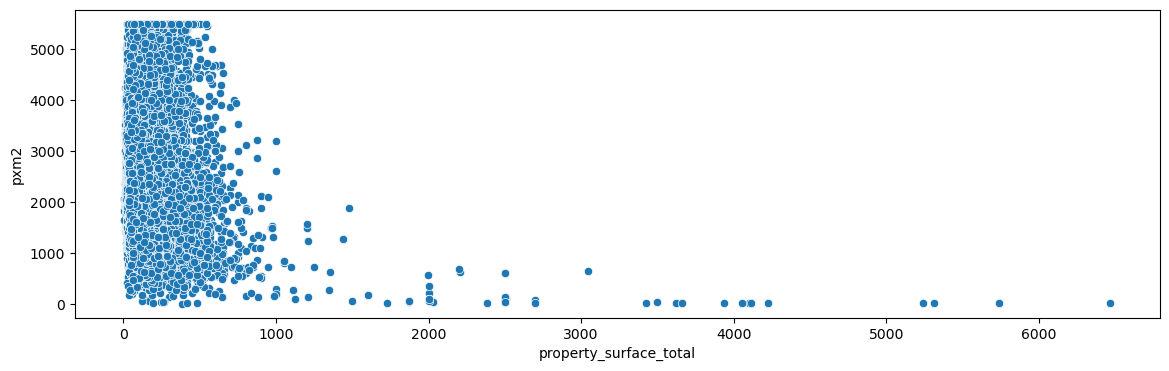

In [17]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2") 
plt.show()

Distribución dividiendo el precio por metro cuadrado en partes iguales.

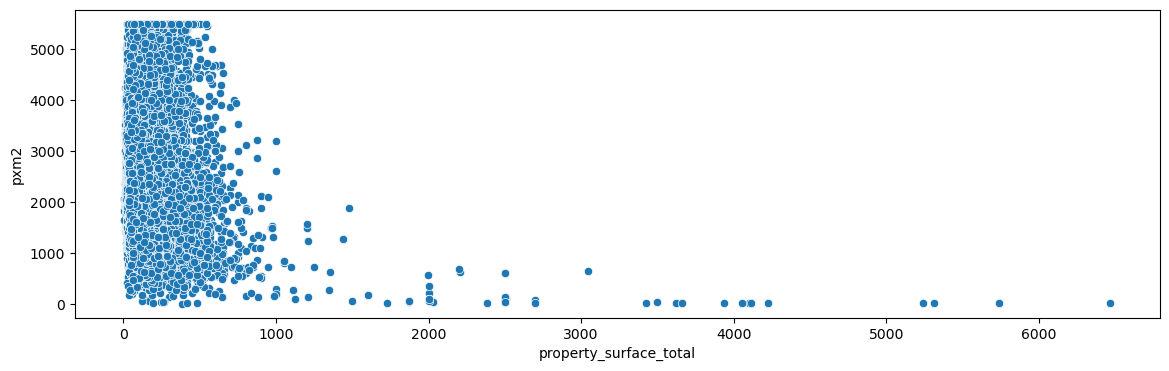

In [18]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2") 
plt.show()

Distrubución 25% bajo, 50% medio, 25% alto.

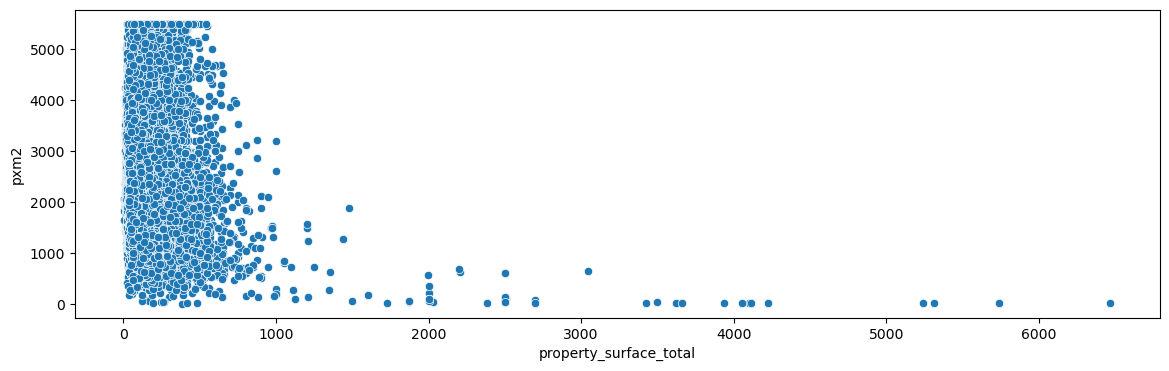

In [19]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2") 
plt.show()

Distribucion agrupando previamente por tipo de propiedad, se observa como se mezclan las categorias a diferencia de los dos casos anteriores.

### Mostrar la distribucion del precio por metro cuadrado por tipo de propiedad

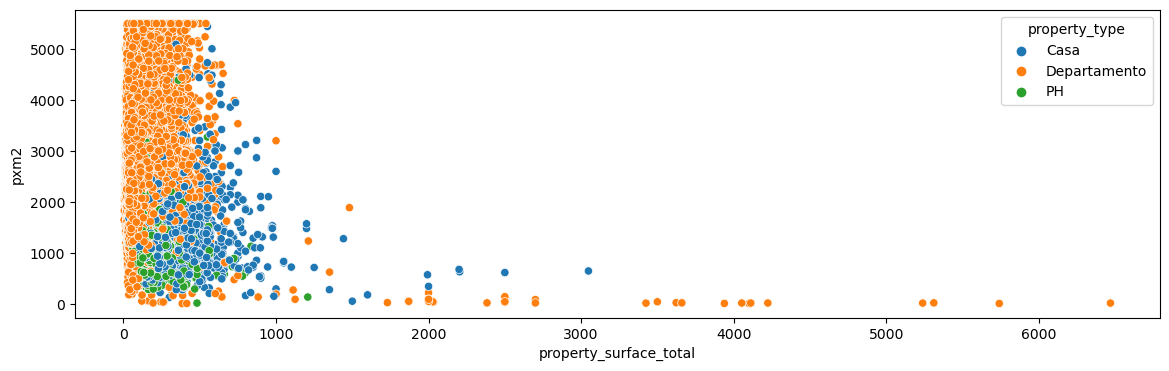

In [20]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2", hue="property_type")
plt.show() 

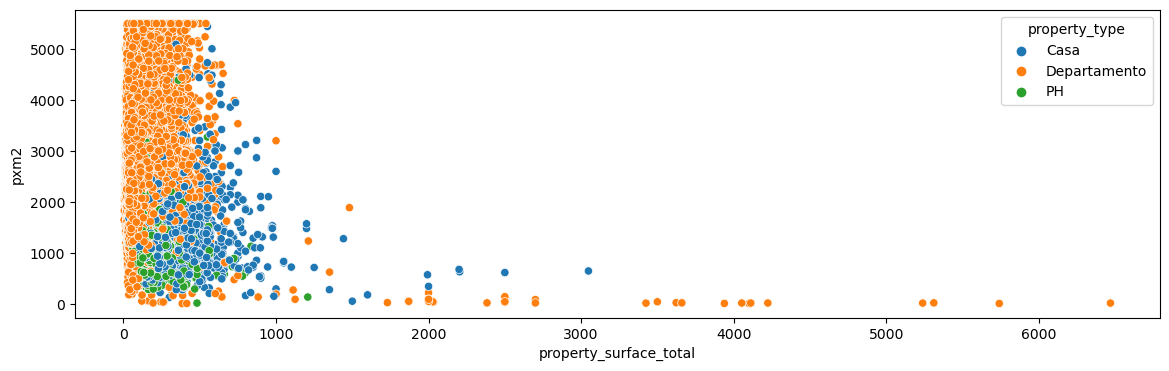

In [21]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2", hue="property_type")
plt.show()

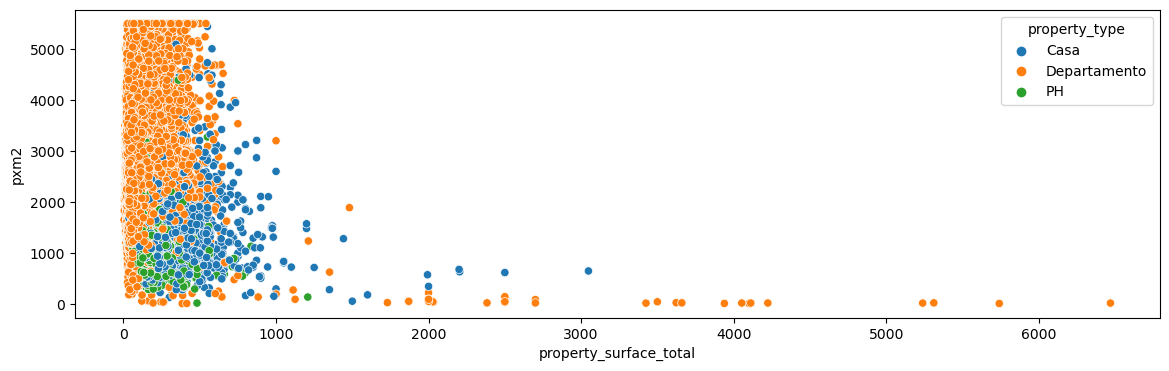

In [22]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2", hue="property_type") 
plt.show()

### Por cada una de las tres alternativas mostrar graficamente la distribución de la nueva variable creada tipo_precio

Agrupamiento en tres partes iguales

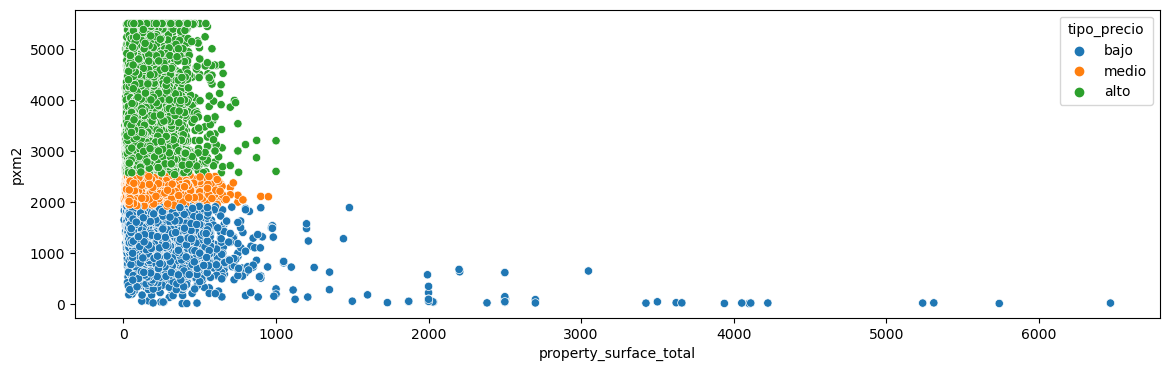

In [23]:
sns.scatterplot(data=df_tprecio1, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

Agrupamiento en tres partes, primera y ultima con 25% cada una, parte del medio con 50%

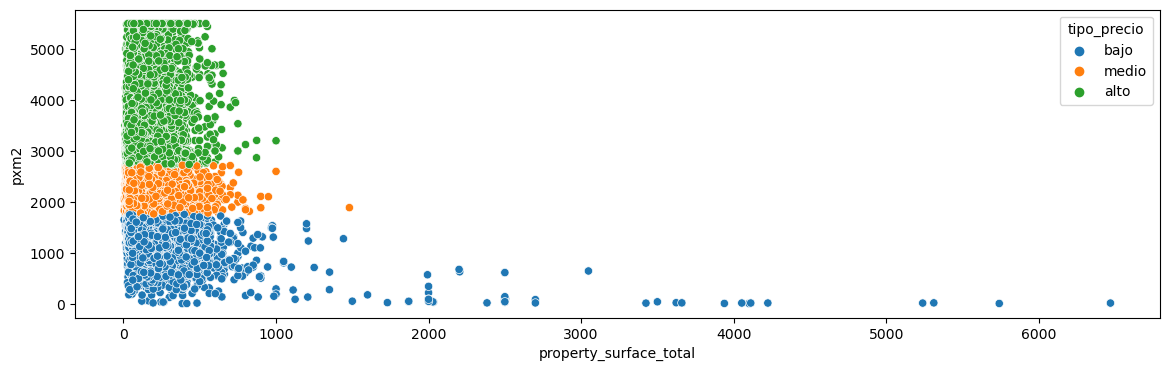

In [24]:
sns.scatterplot(data=df_tprecio2, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

Agrupamiento primero por tipo de propiedad, luego como en el item anterior

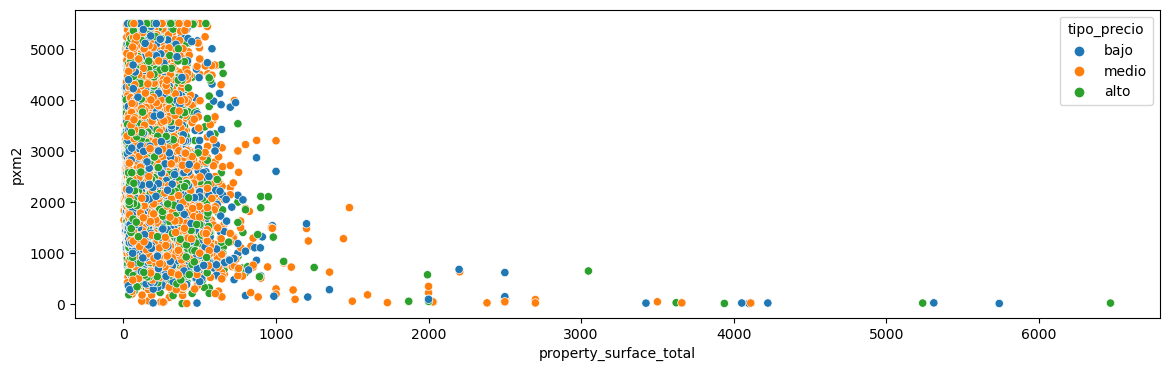

In [25]:
sns.scatterplot(data=df_tprecio3, x='property_surface_total', y="pxm2", hue="tipo_precio") 
plt.show()

### Seleccionar una de las alternativas, justificando la misma

In [26]:
df_tprecio = df_tprecio1
df_tprecio

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82502 -34.603245 -58.489810      Villa del Parque  Departamento   
82503 -34.614063 -58.482814      Villa del Parque  Departamento   
82504 -34.614175 -58.479062      Villa del Parque  Departamento   
82505 -34.614175 -58.479062      Villa del Parque  Departamento   
82506 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82502               4                  3              130.000000   
82503               3                  2               68.000000   
82504               1                  1               51.000000   
82505               1                  1               37.000000   
82506               2                  1               84.000000   

       property_surface_covered  property_price    pxm2 tipo_precio  
0                         133.0        210000.0  1228.0        bajo  
1                          55.0         82900.0  1429.0        bajo  
2                          70.0         99000.0  1414.0        bajo  
3                         104.0        146000.0  1079.0        bajo  
4                          73.0        250000.0  2349.0       medio  
...                         ...             ...     ...         ...  
82502                     100.0        220000.0  1692.0        bajo  
82503                      60.0        161000.0  2368.0       medio  
82504                      30.0         75500.0  1480.0        bajo  
82505                      31.0         74500.0  2014.0       medio  
82506                      84.0        135000.0  1607.0        bajo  

[82507 rows x 11 columns]

Seleccionamos la segunda alternativa antes que la primera debido a que preferimos un agrupamiento equitativo (en cantidad), la tercer alternativa la descartamos ya que podemos notar que si primero agrupamos por propiedad y luego por tipo de precio obtenemos un resultado desordenado.

### Comparar, si aplica, la alternativa seleccionada con la division en 3 grupos obtenida utilizando agrupamiento por K Means

In [27]:
df_kmeans=pd.read_csv("./data/punto2.csv")

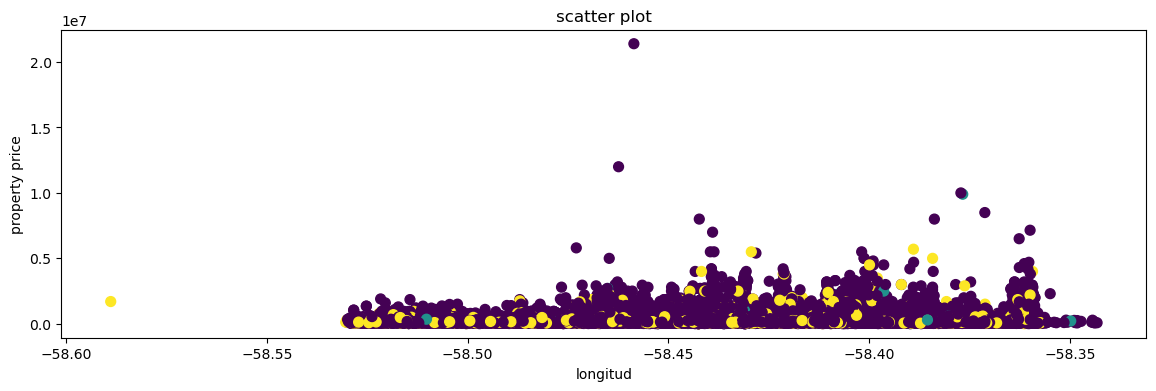

In [28]:
plt.scatter(df_kmeans.longitud, df_kmeans.property_price, c=df_kmeans.colores2, s=50, cmap='viridis')
plt.xlabel('longitud')
plt.ylabel('property price')
plt.title('scatter plot')
plt.show()

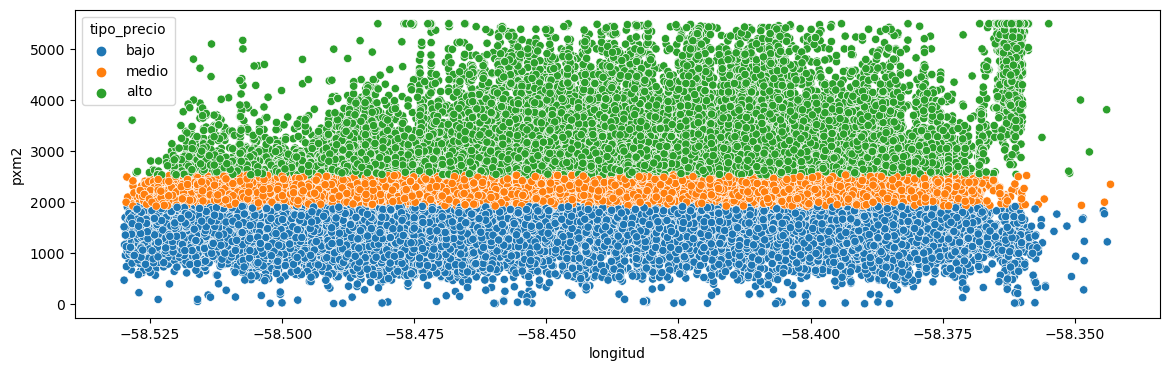

In [29]:
sns.scatterplot(data=df_tprecio, x='longitud', y="pxm2", hue="tipo_precio") 
plt.show()

Se pueden comparar con la alternativa seleccionada ya que, como en el gráfico de kmeans, se puede observar que mientras más a la derecha vas mayor porcentaje de precios altos hay, esto quiere decir que, en barrios como podría ser Palermo el precio por metro cuadrado y su precio real son más elevados que en otras zonas. 

### Mostrar en un mapa de CABA los avisos coloreados por tipo_precio

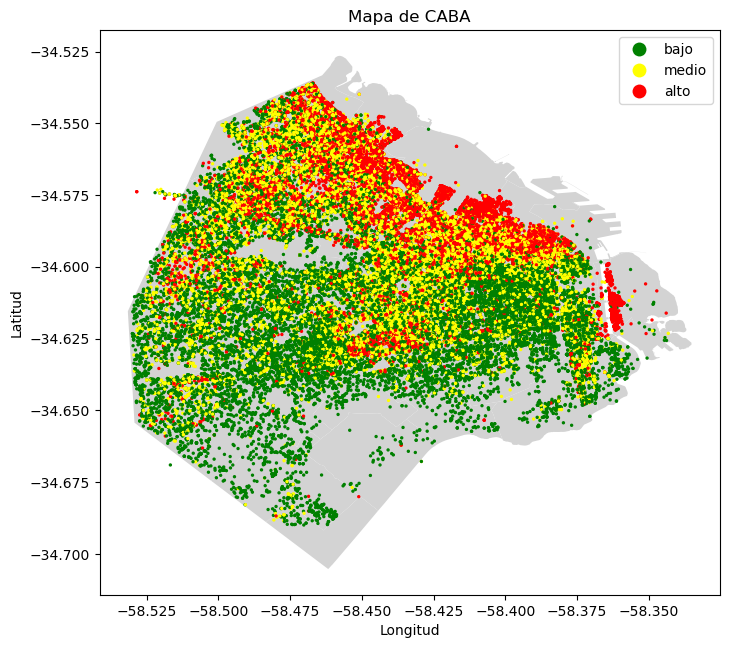

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
barrios = gp.read_file("barrios.geojson")
ax.set_title('Mapa de CABA')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
barrios.plot(ax=ax,column='BARRIO', color='lightgrey')

color_dict = {'bajo':'green',  
              'medio':'yellow',
              'alto':'red' }

puntos = gp.GeoDataFrame(df_tprecio.tipo_precio, geometry=gp.points_from_xy(df_tprecio.longitud, df_tprecio.latitud))    
puntos.plot(ax = ax, column='tipo_precio', markersize=2, legend=True, 
            cmap=colors.ListedColormap(list(color_dict.values())))

plt.show()

# Ejercicio 3b

Entrenamiento y predicción. Predecir el valor del atributo tipo_precio, excluyendo del entrenamiento la variable price, pxm2, y cualquier otra variable que pueda contener información del precio de venta.

Realizar las tareas de ingeniería de características necesarias para trabajar con cada algoritmos (encoding, normalización, etc).

In [31]:
df_EyP=df_tprecio.copy()

In [32]:
df_EyP.dtypes

latitud                      float64
longitud                     float64
place_l3                      object
property_type                 object
property_rooms                 int64
property_bedrooms              int64
property_surface_total       float64
property_surface_covered     float64
property_price               float64
pxm2                         float64
tipo_precio                 category
dtype: object

Quito variables indicativas del precio de venta:

In [33]:
df_EyP.drop(['property_price', 'pxm2'], axis=1, inplace=True)

## Modelo 1 - Árbol de decisión

### Metricas

- **Accuracy:**
El calculo de la precisión de una clasificacion mide la cantidad de casos verdaderos acertados en base al total de casos detectados.

- **Recall:** 
Calcula la cantidad de casos verdaderos acertados en base a la totalidad de casos detectados, debido a que nuestro analisis es multiclase, debemos utilizar una de las siguientes medidas:
- Macro-recall: promedio del recall score de cada clase.
- Weighted-recall: ponderado del recall score de cada clase.
- Micro-recall: precisión general del modelo.

- **f1 score:**
Combinación de las medidas de precisión y recall en un sólo valor, debido a que nuestro analisis es multiclase, debemos utilizar una de las siguientes medidas:
- Macro-f1: promedio del f1 score de cada clase.
- Weighted-f1: ponderado del f1 score de cada clase.
- Micro-f1: el valor de Micro-recall.

En este caso utilizaremos Weigthed-recall y Weighted-f1

### Ajuste del dataset 

Creamos una copia del dataset del punto 1d:

In [34]:
df_dTree=df_EyP.copy()

Transformo variables categoricas para poder utilizarlas como predictorias

In [35]:
df_dTree = pd.get_dummies(df_dTree, columns=["place_l3","property_type"], drop_first=True)
df_dTree.head()

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.589974 -58.459133               4                  3   
1 -34.637319 -58.361124               3                  2   
2 -34.628647 -58.361871               4                  3   
3 -34.610027 -58.401934               4                  2   
4 -34.631621 -58.416825               4                  2   

   property_surface_total  property_surface_covered tipo_precio  \
0              171.000000                     133.0        bajo   
1               58.000000                      55.0        bajo   
2               70.000000                      70.0        bajo   
3              135.327513                     104.0        bajo   
4              106.415511                      73.0       medio   

   place_l3_Agronomía  place_l3_Almagro  place_l3_Balvanera  ...  \
0                   0                 0                   0  ...   
1                   0                 0                   0  ...   
2                   0                 0                   0  ...   
3                   0                 0                   0  ...   
4                   0                 0                   0  ...   

   place_l3_Villa Ortuzar  place_l3_Villa Pueyrredón  place_l3_Villa Real  \
0                       0                          0                    0   
1                       0                          0                    0   
2                       0                          0                    0   
3                       0                          0                    0   
4                       0                          0                    0   

   place_l3_Villa Riachuelo  place_l3_Villa Santa Rita  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   place_l3_Villa Soldati  place_l3_Villa Urquiza  place_l3_Villa del Parque  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       0                       0                          0   
4                       0                       0                          0   

   property_type_Departamento  property_type_PH  
0                           0                 0  
1                           1                 0  
2                           1                 0  
3                           1                 0  
4                           0                 1  

[5 rows x 65 columns]

Variables (features) que clasifican y variable (target) a la que quiero calcular

In [36]:
#Creo un dataset con los features que voy a usar para clasificar
df_dTree_x=df_dTree.drop(['tipo_precio'], axis='columns', inplace=False)

#Creo un dataset con la variable target
df_dTree_y = df_dTree['tipo_precio'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_dTree_x, 
                                                    df_dTree_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2)

### Prueba con el modelo sin optimización

In [37]:
arbolcv=DecisionTreeClassifier()

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier()

In [38]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['alto', 'medio', 'medio', ..., 'medio', 'medio', 'bajo'],
      dtype=object)

In [39]:
y_test.values

['alto', 'medio', 'medio', 'alto', 'alto', ..., 'medio', 'alto', 'medio', 'medio', 'bajo']
Length: 16502
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [40]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6520421767058538
Recall: 0.6520421767058538
f1 score: 0.651080733165923


In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.69      0.71      0.70      5444
        bajo       0.71      0.72      0.72      5564
       medio       0.55      0.53      0.54      5494

    accuracy                           0.65     16502
   macro avg       0.65      0.65      0.65     16502
weighted avg       0.65      0.65      0.65     16502



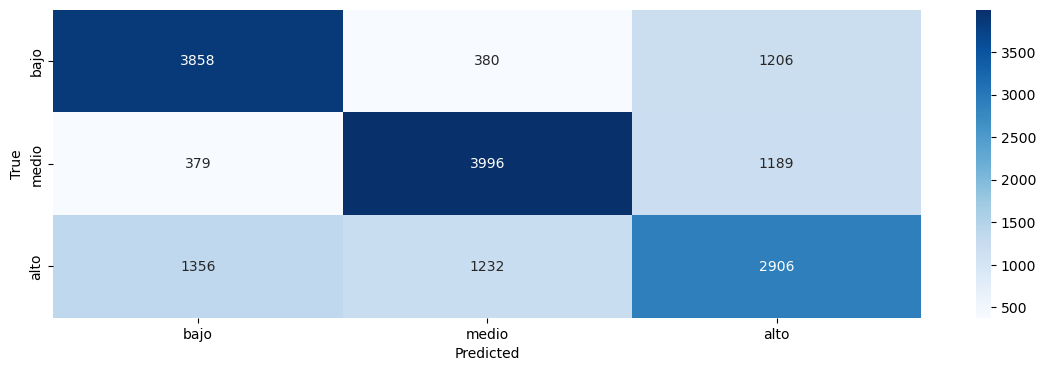

In [42]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

El modelo clasifica correctamente mas de lo que hace erroneamente.

### Optimización de hiperparametros

In [43]:
print(x_train.shape[0])

66005


La cantidad de entradas en nuestro conjunto de entrenamiento es de 66130, elejimos una cantidad de folds de manera tal que quede cada subconjunto con igual cantidad de entradas.

In [44]:
folds = 10

In [45]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,10), 
               'max_depth':list(range(1,16))}
                
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

grid_search = GridSearchCV(
                estimator=base_tree,
                param_grid=params_grid, 
                cv = kfoldcv, 
                n_jobs = -1,
                return_train_score='True'
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             return_train_score='True')

In [46]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 15}
0.6298009530236466


Atributos considerados y su importancia

In [47]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_dTree.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

place_l3_Villa Santa Rita: 4.67511486578447e-06
place_l3_Villa Riachuelo: 2.059617270675569e-05
place_l3_Villa Lugano: 2.8802276843992144e-05
place_l3_Tribunales: 3.9372655088851886e-05
place_l3_Chacarita: 5.8166893634946734e-05
place_l3_Monserrat: 7.750476140521185e-05
place_l3_Caballito: 8.585498320606963e-05
place_l3_Paternal: 9.042222163941384e-05
place_l3_Villa Real: 9.59023562842268e-05
place_l3_Flores: 0.00011324015969280257
place_l3_Palermo: 0.00014185269072087653
place_l3_San Telmo: 0.00015008987443890196
place_l3_Parque Avellaneda: 0.00018927812299391366
place_l3_Parque Chacabuco: 0.00018946117567384543
place_l3_Villa Pueyrredón: 0.00019050941638576018
place_l3_Liniers: 0.00019521097757776377
place_l3_Velez Sarsfield: 0.0002010696835340273
place_l3_Recoleta: 0.0002888719487899463
place_l3_San Cristobal: 0.0002966735787733876
place_l3_Las Cañitas: 0.00033294720949242996
place_l3_Boca: 0.0003651463824599728
place_l3_Parque Centenario: 0.00045545006661305967
place_l3_Villa Ortuz

Nuestro atributo de mayor importancia es la latitud sobre la cual se ubica la propiedad.

### Construcción del árbol de decisión con mejores parametros

Creamos el árbol con los mejores hiperparametros obtenidos en el item anterior y lo entrenamos

In [48]:
arbolcv=DecisionTreeClassifier().set_params(**grid_search.best_params_)

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=15)

#### Grafico del árbol de decisión

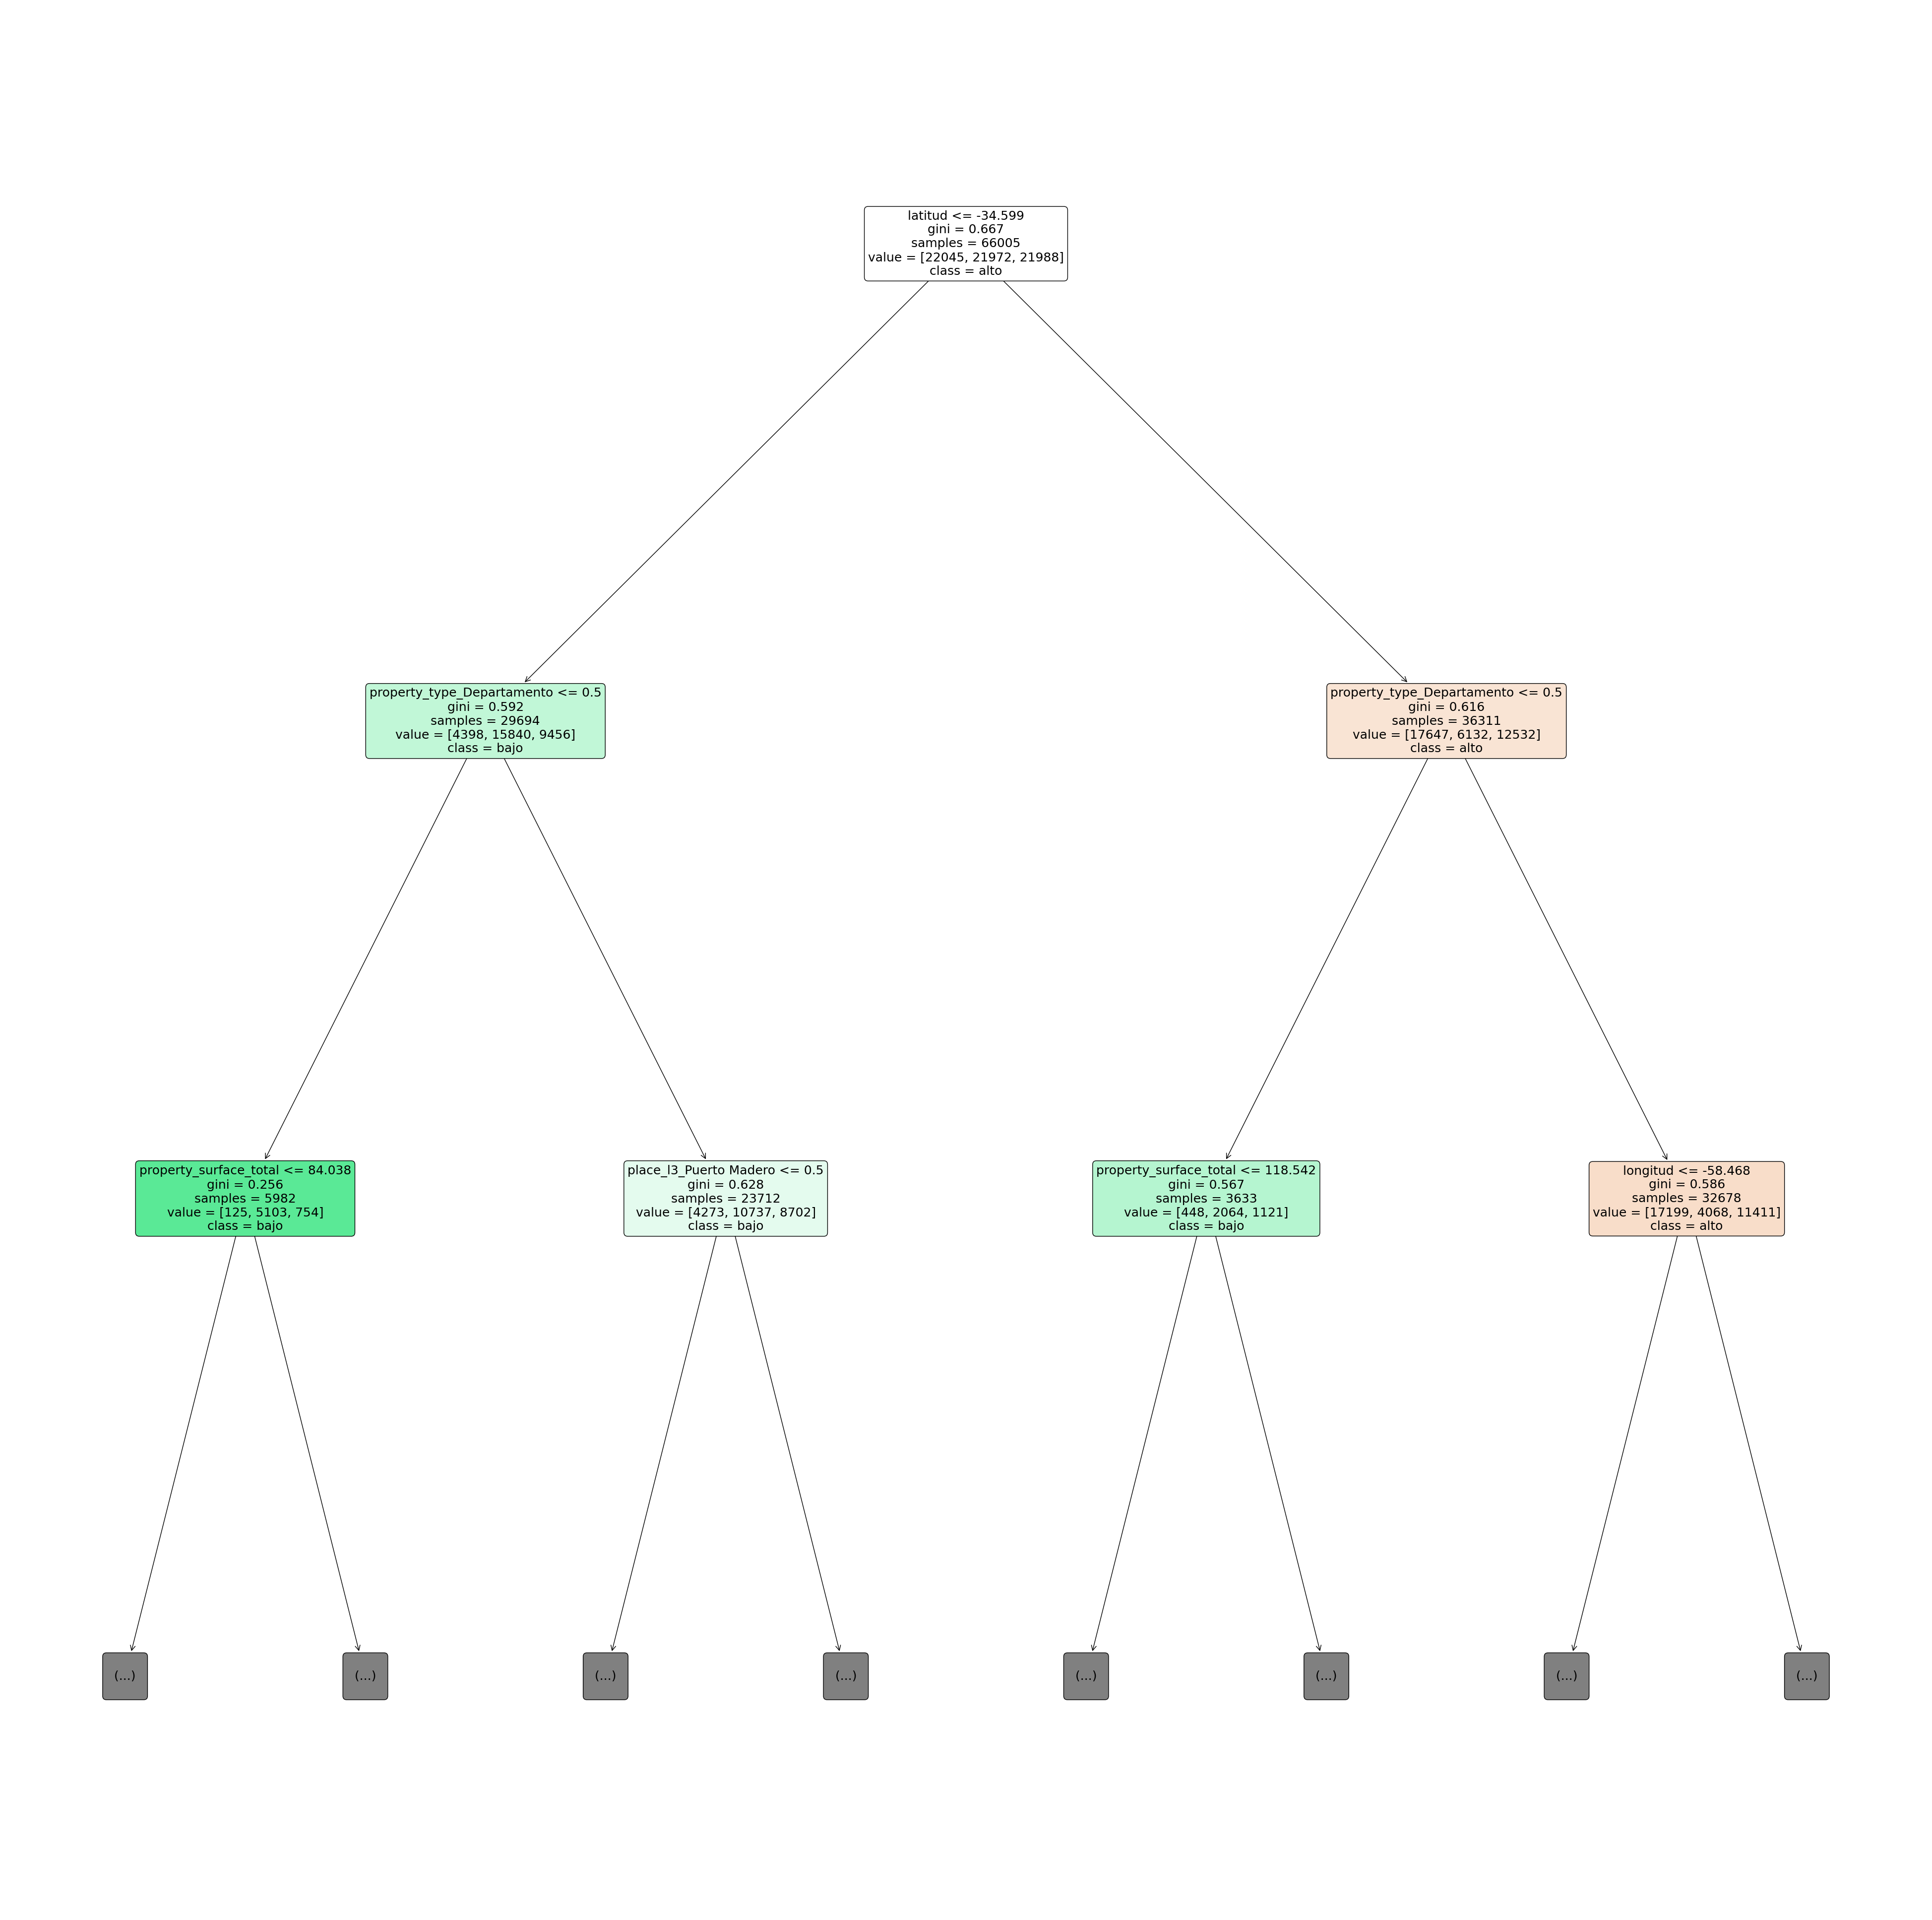

In [49]:
plt.figure(figsize=(50,50))

tree_plot=tree.plot_tree(arbolcv,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])
plt.show(tree_plot)

#### Analisis del árbol de decisión

In [50]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- latitud <= -34.60
|   |--- property_type_Departamento <= 0.50
|   |   |--- property_surface_total <= 84.04
|   |   |   |--- longitud <= -58.41
|   |   |   |   |--- latitud <= -34.62
|   |   |   |   |   |--- place_l3_Caballito <= 0.50
|   |   |   |   |   |   |--- longitud <= -58.50
|   |   |   |   |   |   |   |--- property_surface_covered <= 65.41
|   |   |   |   |   |   |   |   |--- property_surface_covered <= 56.50
|   |   |   |   |   |   |   |   |   |--- property_surface_total <= 46.50
|   |   |   |   |   |   |   |   |   |   |--- place_l3_Mataderos <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- place_l3_Mataderos >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- property_surface_total >  46.50
|   |   |   |   |   |   |   |   |   |   |--- longitud <= -58.51
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch o

El criterio principal de categorización es el de la latitud, zona norte o zona sur de CABA, los departamentos de zona norte son considerados de tipo de precio alto si se ubican cercanas al rio (Belgrano, Palermo, etc) y de precio medio en caso contrario. Los departamentos de zona sur son de precio alto si se encuentran dentro de Puerto Madero. Los PH y Casas de zona sur son de precio bajo, mientras que las de zona norte son de precio medio.

### Evaluación de la performance del árbol en el conjunto de evaluación

Entrenamos al modelo y vemos valores predichos

In [51]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['alto', 'bajo', 'medio', ..., 'medio', 'medio', 'bajo'],
      dtype=object)

Valores reales

In [52]:
y_test.values

['alto', 'medio', 'medio', 'alto', 'alto', ..., 'medio', 'alto', 'medio', 'medio', 'bajo']
Length: 16502
Categories (3, object): ['bajo' < 'medio' < 'alto']

Evaluación performance en el conjunto de evaluación.

In [53]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6371348927402739
Recall: 0.6371348927402739
f1 score: 0.6370185583148142


In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.66      0.73      0.69      5444
        bajo       0.74      0.67      0.70      5564
       medio       0.52      0.51      0.51      5494

    accuracy                           0.64     16502
   macro avg       0.64      0.64      0.64     16502
weighted avg       0.64      0.64      0.64     16502



Matriz de confusión

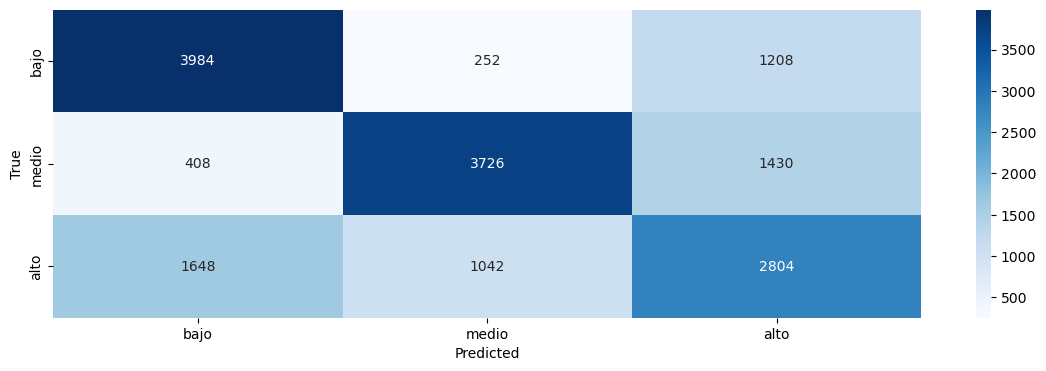

In [55]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Agregar explicación de la matriz.

### Entrenamiento con PCA

#### Ajuste del dataset

In [56]:
df_EyP_pca=pd.read_csv('./data/properati_argentina_2021_pca.csv')
df_EyP_pca.dtypes

Unnamed: 0      int64
cp_1          float64
cp_2          float64
cp_3          float64
cp_4          float64
dtype: object

Agregamos columna tipo_precio  al dataset

In [57]:
df_EyP_pca["tipo_precio"] = df_EyP["tipo_precio"]
df_EyP_pca.drop("Unnamed: 0",axis=1, inplace=True) # Unnamed: 0 se saca guardando el csv sin indice -> df.to_csv(path, index=False)
df_EyP_pca.head(5)

cp_1      cp_2      cp_3      cp_4 tipo_precio
0  1.556266  0.432148 -0.586286 -0.213456        bajo
1 -0.372211 -2.599268  0.381981 -0.307960        bajo
2  0.582906 -2.437438  0.248848 -1.054935        bajo
3  0.691587 -1.100500  0.157895 -0.086541        bajo
4  0.545185 -1.442169 -0.423376 -0.146224       medio

In [58]:
# El dataset probablemente tenga valores nan porque no se corre hace mucho
df_EyP_pca.dropna(inplace=True)
df_EyP_pca.isna().sum()

cp_1           0
cp_2           0
cp_3           0
cp_4           0
tipo_precio    0
dtype: int64

In [59]:
#Creo un dataset con los features que voy a usar para clasificar
df_dTree_x=df_EyP_pca.drop(['tipo_precio'], axis='columns', inplace=False)

#Creo un dataset con la variable target
df_dTree_y = df_EyP_pca['tipo_precio'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_dTree_x, 
                                                    df_dTree_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2)

#### Prueba con el modelo sin optimización

In [60]:
arbolcv=DecisionTreeClassifier()

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier()

In [61]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['bajo', 'alto', 'medio', ..., 'alto', 'alto', 'alto'], dtype=object)

In [62]:
y_test.values

['bajo', 'alto', 'medio', 'bajo', 'bajo', ..., 'alto', 'bajo', 'bajo', 'alto', 'medio']
Length: 16500
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [63]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.3849090909090909
Recall: 0.3849090909090909
f1 score: 0.38460753371165946


In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.41      0.42      0.42      5467
        bajo       0.41      0.40      0.40      5549
       medio       0.34      0.33      0.34      5484

    accuracy                           0.38     16500
   macro avg       0.38      0.38      0.38     16500
weighted avg       0.38      0.38      0.38     16500



Podemos observar que inicialmente la performance del modelo PCA es drasticamente peor que el del dataset con sus dimensiones no reducidas.

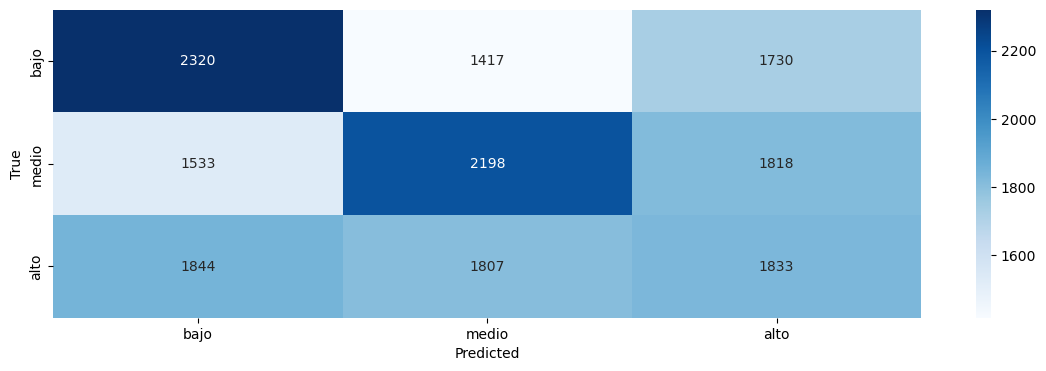

In [65]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Optimización de hiperparametros

In [66]:
folds = 10

In [67]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,10), 
               'max_depth':list(range(1,16))}
                
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

grid_search = GridSearchCV(
                estimator=base_tree,
                param_grid=params_grid, 
                cv = kfoldcv, 
                n_jobs = -1,
                return_train_score='True'
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             return_train_score='True')

In [68]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 8}
0.4430891250740471


In [69]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_EyP_pca.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

cp_1: 0.06636409993066986
cp_4: 0.09270101097414482
cp_2: 0.29182341761216973
cp_3: 0.5491114714830155


Vemos que cp_3 es el atributo de mayor importancia.

#### Construcción del árbol de decisión

Creamos el árbol con los mejores hiperparametros obtenidos en el item anterior y lo entrenamos

In [70]:
arbolcv=DecisionTreeClassifier().set_params(**grid_search.best_params_)

arbolcv.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

#### Grafico del árbol de decisión

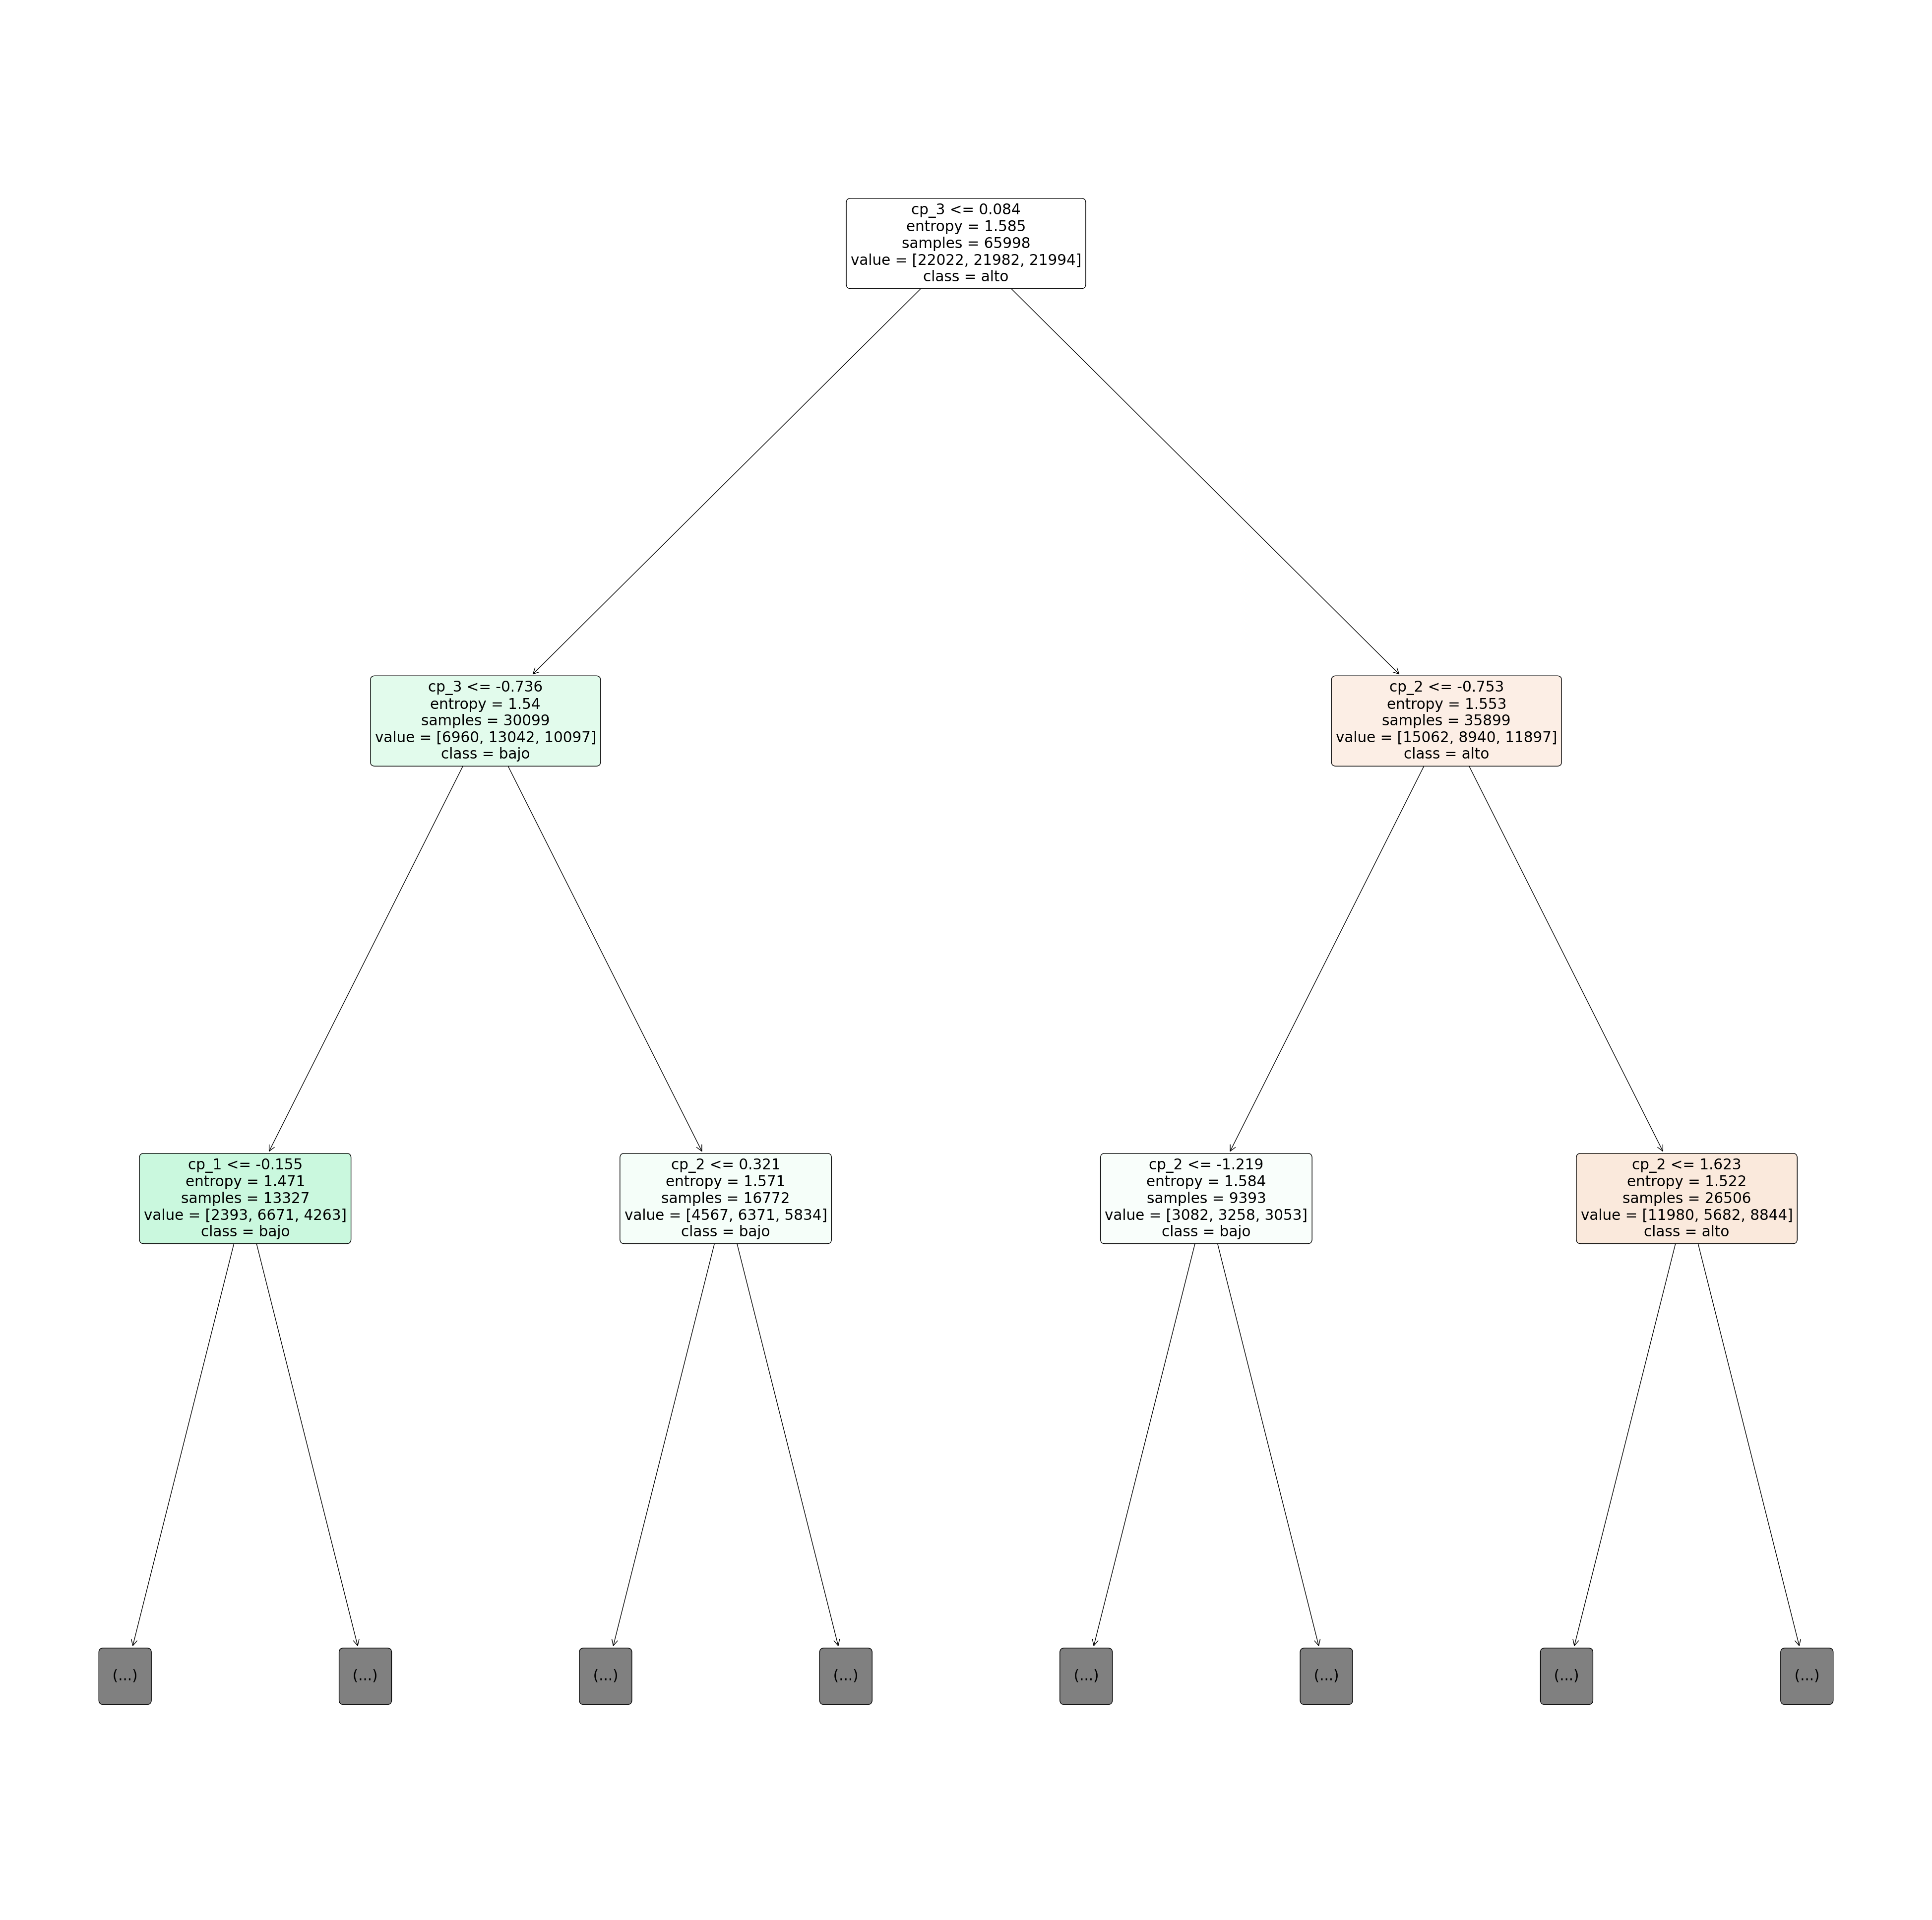

In [71]:
plt.figure(figsize=(50,50))

tree_plot=tree.plot_tree(arbolcv,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])
plt.show(tree_plot)

#### Analisis del árbol de decisión

In [72]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- cp_3 <= 0.08
|   |--- cp_3 <= -0.74
|   |   |--- cp_1 <= -0.15
|   |   |   |--- cp_3 <= -1.34
|   |   |   |   |--- cp_1 <= -1.13
|   |   |   |   |   |--- cp_3 <= -1.74
|   |   |   |   |   |   |--- cp_3 <= -1.74
|   |   |   |   |   |   |   |--- cp_1 <= -1.13
|   |   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |   |--- cp_1 >  -1.13
|   |   |   |   |   |   |   |   |--- class: alto
|   |   |   |   |   |   |--- cp_3 >  -1.74
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |--- cp_3 >  -1.74
|   |   |   |   |   |   |--- cp_2 <= 0.46
|   |   |   |   |   |   |   |--- cp_4 <= 0.96
|   |   |   |   |   |   |   |   |--- class: alto
|   |   |   |   |   |   |   |--- cp_4 >  0.96
|   |   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |--- cp_2 >  0.46
|   |   |   |   |   |   |   |--- cp_2 <= 0.71
|   |   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |   |--- cp_2 >  0.71
|   |   |   |   |   |   |   |   |--- class: baj

EXPLICAR REGLAS DEL ARBOL

#### Evaluación de la performance del árbol de decisión

Entrenamos al modelo y vemos valores predichos

In [73]:
arbolcv_entrenado = arbolcv.fit(X = x_train, y = y_train)
y_pred = arbolcv.predict(x_test)
y_pred

array(['bajo', 'alto', 'alto', ..., 'medio', 'alto', 'bajo'], dtype=object)

In [74]:
y_test.values

['bajo', 'alto', 'medio', 'bajo', 'bajo', ..., 'alto', 'bajo', 'bajo', 'alto', 'medio']
Length: 16500
Categories (3, object): ['bajo' < 'medio' < 'alto']

Evaluación performance en el conjunto de evaluación.

In [75]:
y_pred = arbolcv.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.43927272727272726
Recall: 0.43927272727272726
f1 score: 0.421242082672894


In [76]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.46      0.56      0.51      5467
        bajo       0.45      0.55      0.50      5549
       medio       0.37      0.20      0.26      5484

    accuracy                           0.44     16500
   macro avg       0.43      0.44      0.42     16500
weighted avg       0.43      0.44      0.42     16500



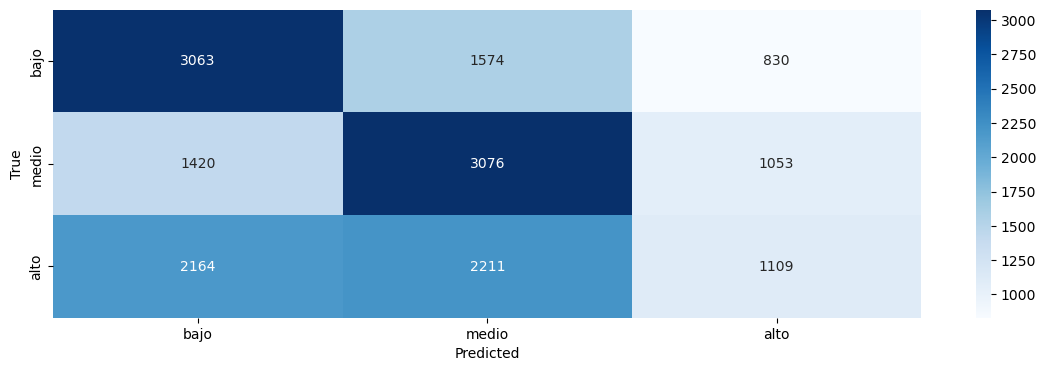

In [77]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AGREGAR EXPLICACIÓN DE LA MATRIZ

## Modelo 2 - Random forest

### Metricas

- **RMSE:**

Agregar metricas

### Ajuste del dataset

In [78]:
df_randomF = df_EyP.copy()
df_randomF = pd.get_dummies(df_randomF, columns=["place_l3","property_type"], drop_first=True)
df_randomF['tipo_precio'] = pd.factorize(df_randomF.tipo_precio)[0]
df_randomF.head()

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.589974 -58.459133               4                  3   
1 -34.637319 -58.361124               3                  2   
2 -34.628647 -58.361871               4                  3   
3 -34.610027 -58.401934               4                  2   
4 -34.631621 -58.416825               4                  2   

   property_surface_total  property_surface_covered  tipo_precio  \
0              171.000000                     133.0            0   
1               58.000000                      55.0            0   
2               70.000000                      70.0            0   
3              135.327513                     104.0            0   
4              106.415511                      73.0            1   

   place_l3_Agronomía  place_l3_Almagro  place_l3_Balvanera  ...  \
0                   0                 0                   0  ...   
1                   0                 0                   0  ...   
2                   0                 0                   0  ...   
3                   0                 0                   0  ...   
4                   0                 0                   0  ...   

   place_l3_Villa Ortuzar  place_l3_Villa Pueyrredón  place_l3_Villa Real  \
0                       0                          0                    0   
1                       0                          0                    0   
2                       0                          0                    0   
3                       0                          0                    0   
4                       0                          0                    0   

   place_l3_Villa Riachuelo  place_l3_Villa Santa Rita  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   place_l3_Villa Soldati  place_l3_Villa Urquiza  place_l3_Villa del Parque  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       0                       0                          0   
4                       0                       0                          0   

   property_type_Departamento  property_type_PH  
0                           0                 0  
1                           1                 0  
2                           1                 0  
3                           1                 0  
4                           0                 1  

[5 rows x 65 columns]

In [79]:
df_randomF_x = df_randomF.drop(columns = "tipo_precio")
df_randomF_y = df_randomF['tipo_precio']

#Generamos los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(
                                        df_randomF_x, 
                                        df_randomF_y, 
                                        test_size=0.2,  #proporcion 80/20
                                        random_state=42
                                    )

### Prueba con el modelo sin optimización

In [80]:
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [81]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''


'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [82]:
# Error test del modelo inicial
y_pred = random_forest.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

El error RMSE de test es: 0.6416445057797643


In [83]:
y_pred

array([0, 1, 0, ..., 0, 2, 2])

In [84]:
y_test.values

array([0, 1, 0, ..., 0, 1, 2])

In [85]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6804629741849473
Recall: 0.6804629741849473
f1 score: 0.679252099862992


In [86]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      5489
           1       0.57      0.55      0.56      5530
           2       0.72      0.75      0.73      5483

    accuracy                           0.68     16502
   macro avg       0.68      0.68      0.68     16502
weighted avg       0.68      0.68      0.68     16502



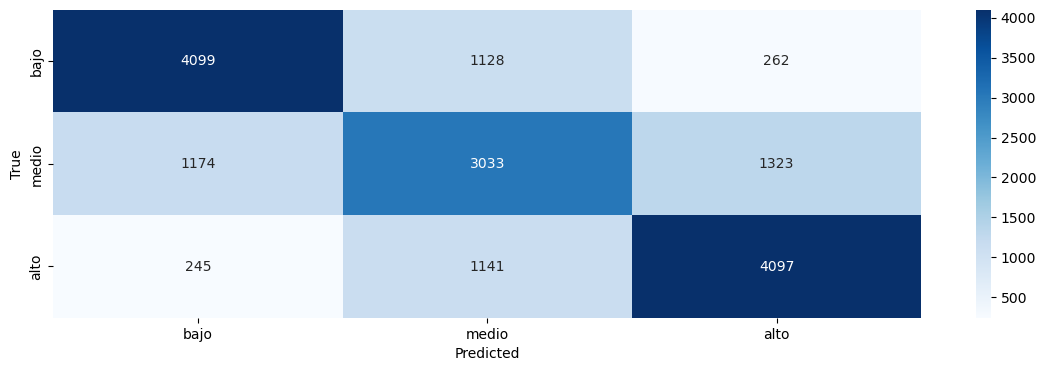

In [87]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Notamos que a diferencia del árbol de decisión, el random forest tiende a clasificar a las propiedades como precio bajo.

### Optimizamos los hiperparámetros

In [88]:
param_dist = {
            'max_depth': list(range(1,16)),
            #'min_samples_leaf': [5,10,20,50,100,200],
            #'n_estimators': [10,25,30,50,100,200],
            #'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5) # 5 folds para cross validation

grid_search = GridSearchCV(
                random_forest,
                param_grid=param_dist, 
                cv = kfoldcv, 
                n_jobs = -1
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]})

In [89]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 15}
0.639042496780547


Atributos considerados y su importancia

In [90]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_randomF.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

place_l3_Villa Real: 4.919732718839569e-06
place_l3_Floresta: 1.4897603004649878e-05
place_l3_Caballito: 4.987643408741884e-05
place_l3_Villa Santa Rita: 6.234100842528996e-05
place_l3_Parque Avellaneda: 7.226560975884137e-05
place_l3_Catalinas: 8.780463733067564e-05
place_l3_San Telmo: 0.00010037512315980592
place_l3_Villa Pueyrredón: 0.00014561284999017234
place_l3_Tribunales: 0.00017448845207405865
place_l3_Villa Riachuelo: 0.000203834574884979
place_l3_Monserrat: 0.000304608235870401
place_l3_Velez Sarsfield: 0.00033049604668302534
tipo_precio: 0.00036966467816960225
place_l3_Las Cañitas: 0.00037294712515811775
place_l3_Villa Lugano: 0.000393252745230371
place_l3_Villa Devoto: 0.00044264001676604916
place_l3_Parque Chacabuco: 0.00047261615297282145
place_l3_Paternal: 0.0004920754315225247
place_l3_Parque Chas: 0.000583885163415783
place_l3_Parque Centenario: 0.000694472058112973
place_l3_Centro / Microcentro: 0.000727843720771035
place_l3_Parque Patricios: 0.0007759013704590379
pla

Nuestro atributo de mayor importancia es...

### Construcción del árbol con mejores parametros

In [91]:
random_forest = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_)

random_forest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, random_state=42)

#### Grafico del árbol

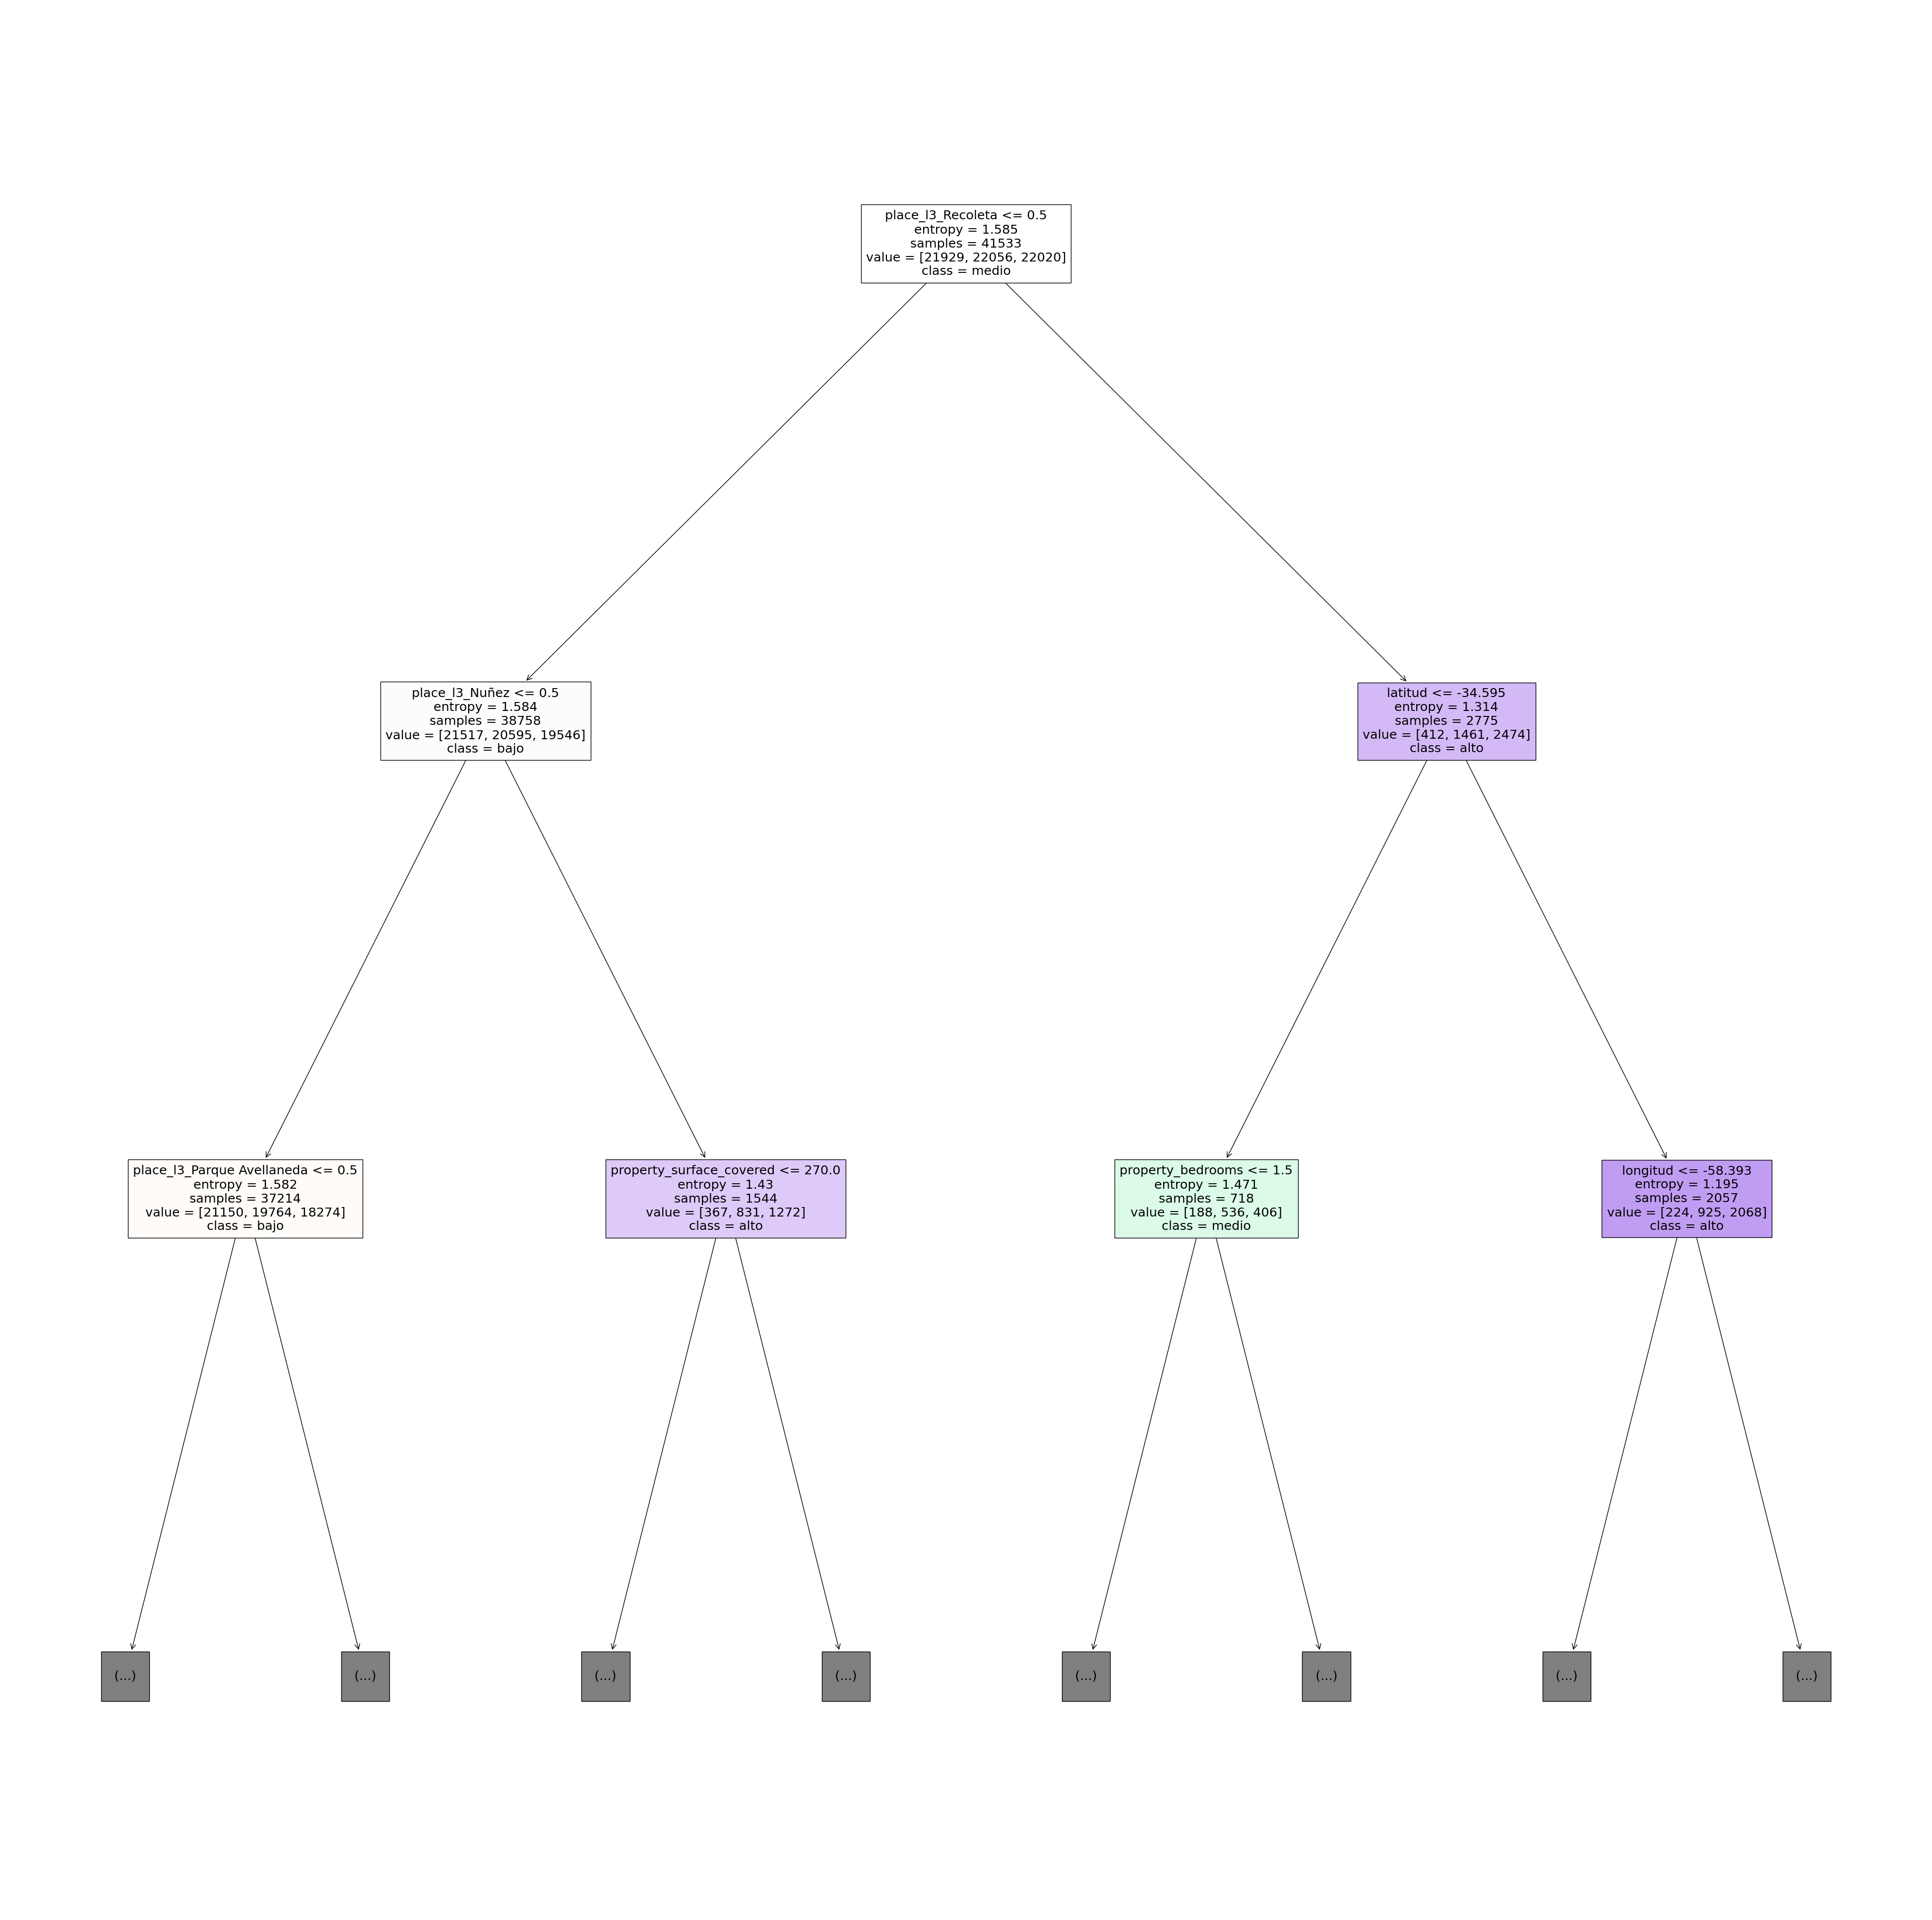

In [92]:
plt.figure(figsize=(50,50))

tree_plot=tree.plot_tree(grid_search.best_estimator_[5], 
                         feature_names = df_randomF_x.columns,
                         filled=True,
                         max_depth=2,
                         class_names=['bajo', 'medio', 'alto'])

plt.show(tree_plot)

#### Analisis del árbol de decisión

In [93]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- cp_3 <= 0.08
|   |--- cp_3 <= -0.74
|   |   |--- cp_1 <= -0.15
|   |   |   |--- cp_3 <= -1.34
|   |   |   |   |--- cp_1 <= -1.13
|   |   |   |   |   |--- cp_3 <= -1.74
|   |   |   |   |   |   |--- cp_3 <= -1.74
|   |   |   |   |   |   |   |--- cp_1 <= -1.13
|   |   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |   |--- cp_1 >  -1.13
|   |   |   |   |   |   |   |   |--- class: alto
|   |   |   |   |   |   |--- cp_3 >  -1.74
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |--- cp_3 >  -1.74
|   |   |   |   |   |   |--- cp_2 <= 0.46
|   |   |   |   |   |   |   |--- cp_4 <= 0.96
|   |   |   |   |   |   |   |   |--- class: alto
|   |   |   |   |   |   |   |--- cp_4 >  0.96
|   |   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |--- cp_2 >  0.46
|   |   |   |   |   |   |   |--- cp_2 <= 0.71
|   |   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |   |--- cp_2 >  0.71
|   |   |   |   |   |   |   |   |--- class: baj

EXPLICAR REGLAS DEL ARBOL

### Evaluación de la performance del árbol en el conjunto de evaluación

In [94]:
random_forest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, random_state=42)

Error luego de setear los hiperparámetros

In [95]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [96]:
y_pred = random_forest.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")

El error RMSE de test es: 0.7053477530072689


In [97]:
y_pred

array([1, 1, 0, ..., 0, 1, 2])

In [98]:
y_test.values

array([0, 1, 0, ..., 0, 1, 2])

In [99]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.6333777723912253
Recall: 0.6333777723912253
f1 score: 0.6272091910035821


In [100]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      5489
           1       0.52      0.44      0.47      5530
           2       0.65      0.75      0.70      5483

    accuracy                           0.63     16502
   macro avg       0.63      0.63      0.63     16502
weighted avg       0.63      0.63      0.63     16502



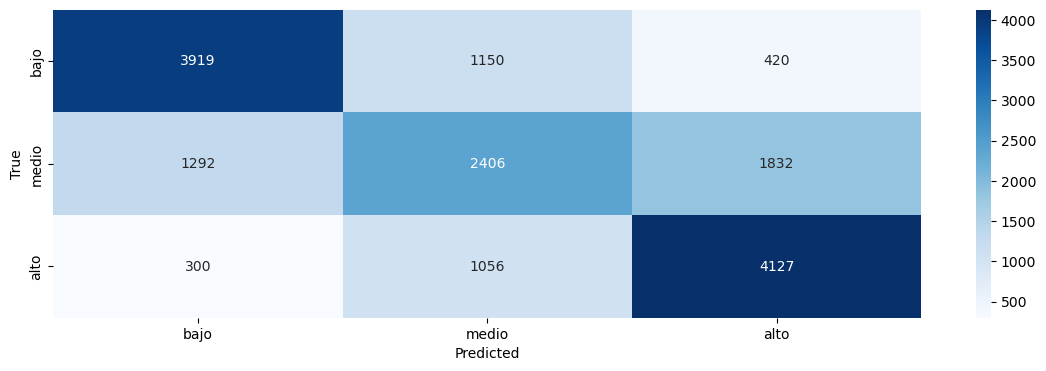

In [101]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Entrenamiento con PCA

#### Ajuste del dataset

In [102]:
df_randomF_pca=pd.read_csv('./data/properati_argentina_2021_pca.csv')

df_randomF_pca["tipo_precio"] = df_EyP["tipo_precio"]
df_randomF_pca.drop("Unnamed: 0",axis=1, inplace=True)

df_randomF_pca.dropna(inplace=True)

In [103]:
df_randomF_pca_x = df_randomF_pca.drop(columns = "tipo_precio")
df_randomF_pca_y = df_randomF_pca['tipo_precio']

#Generamos los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(
                                        df_randomF_pca_x, 
                                        df_randomF_pca_y, 
                                        test_size=0.2,  #proporcion 80/20
                                        random_state=42
                                    )

#### Prueba con el modelo sin optimización

In [104]:
random_forest_pca = RandomForestClassifier(random_state=42)
random_forest_pca.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [105]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [106]:
y_pred = random_forest_pca.predict(X = x_test)

'''rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")'''

'rmse = mean_squared_error(\n        y_true  = y_test,\n        y_pred  = y_pred,\n        squared = False\n       )\n\nprint(f"El error RMSE de test es: {rmse}")'

In [107]:
y_pred

array(['bajo', 'alto', 'medio', ..., 'bajo', 'bajo', 'alto'], dtype=object)

In [108]:
y_test.values

['medio', 'bajo', 'alto', 'alto', 'bajo', ..., 'alto', 'bajo', 'alto', 'medio', 'alto']
Length: 16500
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [109]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.41454545454545455
Recall: 0.41454545454545455
f1 score: 0.4128955757814914


In [110]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.44      0.46      0.45      5481
        bajo       0.45      0.46      0.45      5597
       medio       0.35      0.32      0.33      5422

    accuracy                           0.41     16500
   macro avg       0.41      0.41      0.41     16500
weighted avg       0.41      0.41      0.41     16500



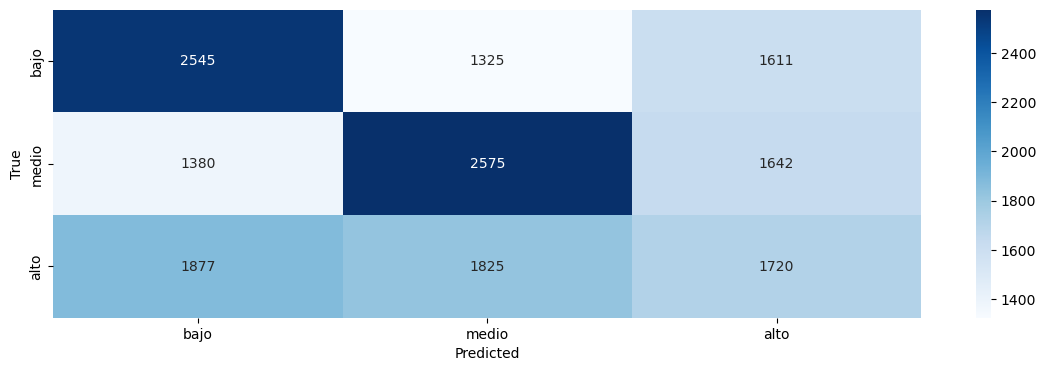

In [111]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

EXPLICAR MATRIZ DE CONFUSIÓN

#### Optimización de hiperparametros

In [112]:
param_dist = {
            'max_depth': list(range(1,16)),
            #'min_samples_leaf': [5,10,20,50,100,200],
            #'n_estimators': [10,25,30,50,100,200],
            #'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5) # 5 folds para cross validation

grid_search = GridSearchCV(
                random_forest_pca,
                param_grid=param_dist,
                cv = kfoldcv, 
                n_jobs = -1
            )

grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]})

In [113]:
#Mejores hiperparametros del arbol
print(grid_search.best_params_)
#Mejor métrica
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 9}
0.4513166722915189


Atributos considerados y su importancia

In [114]:
best_tree = grid_search.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_randomF_pca.columns)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

cp_1: 0.13336361184876666
cp_4: 0.14164834078568184
cp_2: 0.2605748770602025
cp_3: 0.46441317030534895


Nuestro atributo de mayor importancia es...

#### Construcción del árbol con mejores parametros

In [115]:
random_forest_pca = RandomForestClassifier(random_state=42).set_params(**grid_search.best_params_)

random_forest_pca.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, random_state=42)

#### Grafico del árbol

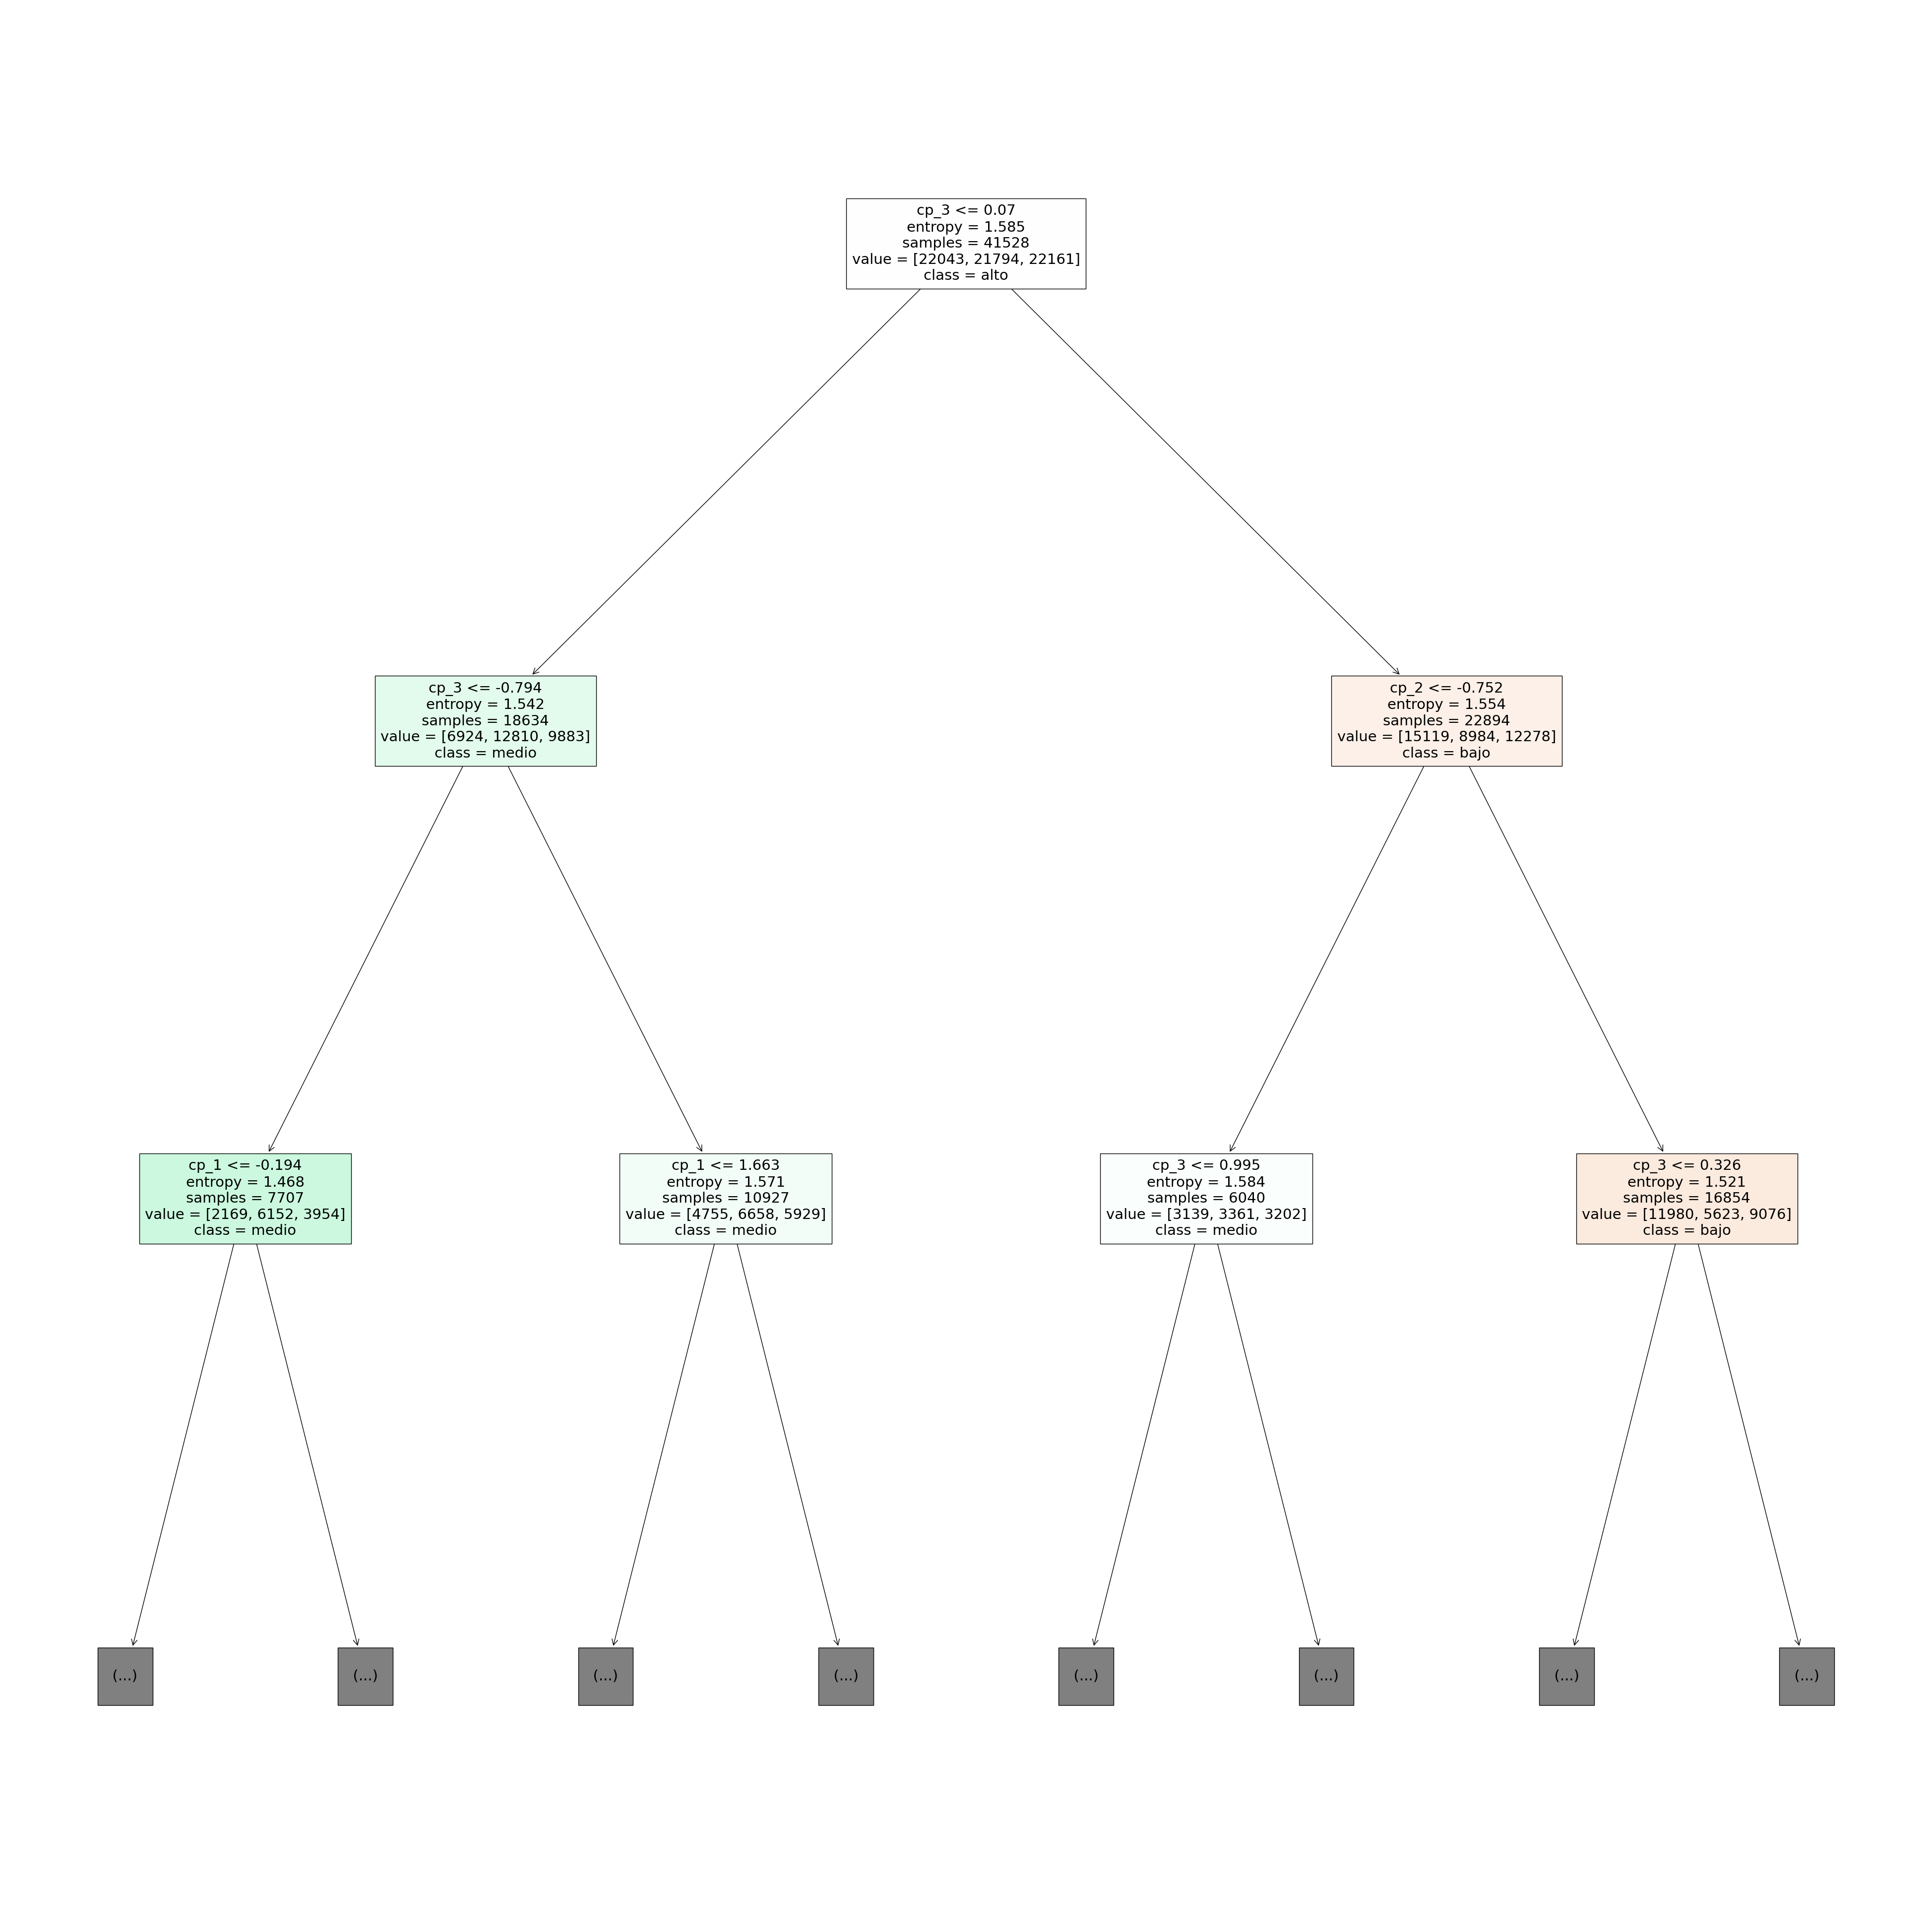

In [116]:

plt.figure(figsize=(50,50))

'''tree_plot=tree.plot_tree(random_forest,
                        feature_names=x_train.columns.to_list(),
                        filled=True,
                        rounded=True,
                        max_depth=2,
                        class_names=['alto', 'bajo', 'medio'])'''

tree_plot=tree.plot_tree(grid_search.best_estimator_[5], 
                         feature_names = df_randomF_pca_x.columns,
                         filled=True,
                         max_depth=2,
                         class_names=['bajo', 'medio', 'alto'])

plt.show(tree_plot)

##### Analisis del árbol de decisión

In [117]:
reglas = export_text(arbolcv, feature_names=list(df_dTree_x))
print(reglas)

|--- cp_3 <= 0.08
|   |--- cp_3 <= -0.74
|   |   |--- cp_1 <= -0.15
|   |   |   |--- cp_3 <= -1.34
|   |   |   |   |--- cp_1 <= -1.13
|   |   |   |   |   |--- cp_3 <= -1.74
|   |   |   |   |   |   |--- cp_3 <= -1.74
|   |   |   |   |   |   |   |--- cp_1 <= -1.13
|   |   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |   |--- cp_1 >  -1.13
|   |   |   |   |   |   |   |   |--- class: alto
|   |   |   |   |   |   |--- cp_3 >  -1.74
|   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |--- cp_3 >  -1.74
|   |   |   |   |   |   |--- cp_2 <= 0.46
|   |   |   |   |   |   |   |--- cp_4 <= 0.96
|   |   |   |   |   |   |   |   |--- class: alto
|   |   |   |   |   |   |   |--- cp_4 >  0.96
|   |   |   |   |   |   |   |   |--- class: bajo
|   |   |   |   |   |   |--- cp_2 >  0.46
|   |   |   |   |   |   |   |--- cp_2 <= 0.71
|   |   |   |   |   |   |   |   |--- class: medio
|   |   |   |   |   |   |   |--- cp_2 >  0.71
|   |   |   |   |   |   |   |   |--- class: baj

EXPLICAR REGLAS DEL ARBOL

#### Evaluación de la performance del árbol en el conjunto de evaluación

In [118]:
random_forest_pca.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, random_state=42)

Error luego de setear los hiperparámetros

In [119]:
'''scores = cross_val_score(
                    random_forest,
                    df_randomF_x,
                    df_randomF_y,
                    scoring="neg_mean_squared_error",
                    cv=10,
                    n_jobs=-1
                )

rmse = np.sqrt(-scores)
print("Valores RMSE: ", np.round(rmse, 2))
print("Promedio RMSE: ", np.mean(rmse))'''

'scores = cross_val_score(\n                    random_forest,\n                    df_randomF_x,\n                    df_randomF_y,\n                    scoring="neg_mean_squared_error",\n                    cv=10,\n                    n_jobs=-1\n                )\n\nrmse = np.sqrt(-scores)\nprint("Valores RMSE: ", np.round(rmse, 2))\nprint("Promedio RMSE: ", np.mean(rmse))'

In [120]:
y_pred = random_forest_pca.predict(X = x_test)

'''rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error RMSE de test es: {rmse}")'''

'rmse = mean_squared_error(\n        y_true  = y_test,\n        y_pred  = y_pred,\n        squared = False\n       )\n\nprint(f"El error RMSE de test es: {rmse}")'

In [121]:
y_pred

array(['medio', 'bajo', 'alto', ..., 'bajo', 'medio', 'alto'],
      dtype=object)

In [122]:
y_test.values

['medio', 'bajo', 'alto', 'alto', 'bajo', ..., 'alto', 'bajo', 'alto', 'medio', 'alto']
Length: 16500
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [123]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred,average="weighted")
f1=f1_score(y_test,y_pred,average="weighted")

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.45115151515151514
Recall: 0.45115151515151514
f1 score: 0.43758103019164163


In [124]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.48      0.57      0.52      5481
        bajo       0.47      0.55      0.51      5597
       medio       0.37      0.23      0.29      5422

    accuracy                           0.45     16500
   macro avg       0.44      0.45      0.44     16500
weighted avg       0.44      0.45      0.44     16500



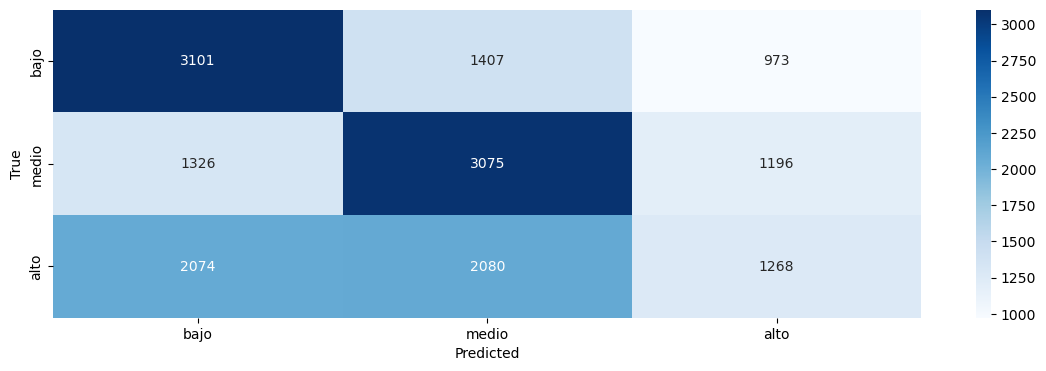

In [125]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 3 - KNN

### Prueba con el modelo sin optimización

In [126]:
df_KNN=df_EyP.copy()
df_KNN

latitud   longitud              place_l3 property_type  \
0     -34.589974 -58.459133               Palermo          Casa   
1     -34.637319 -58.361124                  Boca  Departamento   
2     -34.628647 -58.361871                  Boca  Departamento   
3     -34.610027 -58.401934                  Once  Departamento   
4     -34.631621 -58.416825                 Boedo            PH   
...          ...        ...                   ...           ...   
82502 -34.603245 -58.489810      Villa del Parque  Departamento   
82503 -34.614063 -58.482814      Villa del Parque  Departamento   
82504 -34.614175 -58.479062      Villa del Parque  Departamento   
82505 -34.614175 -58.479062      Villa del Parque  Departamento   
82506 -34.599790 -58.373411  Centro / Microcentro  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
0                   4                  3              171.000000   
1                   3                  2               58.000000   
2                   4                  3               70.000000   
3                   4                  2              135.327513   
4                   4                  2              106.415511   
...               ...                ...                     ...   
82502               4                  3              130.000000   
82503               3                  2               68.000000   
82504               1                  1               51.000000   
82505               1                  1               37.000000   
82506               2                  1               84.000000   

       property_surface_covered tipo_precio  
0                         133.0        bajo  
1                          55.0        bajo  
2                          70.0        bajo  
3                         104.0        bajo  
4                          73.0       medio  
...                         ...         ...  
82502                     100.0        bajo  
82503                      60.0       medio  
82504                      30.0        bajo  
82505                      31.0       medio  
82506                      84.0        bajo  

[82507 rows x 9 columns]

In [127]:
df_KNN = pd.get_dummies(df_KNN, columns=["place_l3","property_type"], drop_first=True)

In [128]:
df_KNN['tipo_precio'] = df_KNN['tipo_precio'].map({'bajo':0,'medio':1,'alto':2},na_action=None)
df_KNN['tipo_precio'].astype('int64')

0        0
1        0
2        0
3        0
4        1
        ..
82502    0
82503    1
82504    0
82505    1
82506    0
Name: tipo_precio, Length: 82507, dtype: int64

In [129]:
df_KNN.head()

latitud   longitud  property_rooms  property_bedrooms  \
0 -34.589974 -58.459133               4                  3   
1 -34.637319 -58.361124               3                  2   
2 -34.628647 -58.361871               4                  3   
3 -34.610027 -58.401934               4                  2   
4 -34.631621 -58.416825               4                  2   

   property_surface_total  property_surface_covered tipo_precio  \
0              171.000000                     133.0           0   
1               58.000000                      55.0           0   
2               70.000000                      70.0           0   
3              135.327513                     104.0           0   
4              106.415511                      73.0           1   

   place_l3_Agronomía  place_l3_Almagro  place_l3_Balvanera  ...  \
0                   0                 0                   0  ...   
1                   0                 0                   0  ...   
2                   0                 0                   0  ...   
3                   0                 0                   0  ...   
4                   0                 0                   0  ...   

   place_l3_Villa Ortuzar  place_l3_Villa Pueyrredón  place_l3_Villa Real  \
0                       0                          0                    0   
1                       0                          0                    0   
2                       0                          0                    0   
3                       0                          0                    0   
4                       0                          0                    0   

   place_l3_Villa Riachuelo  place_l3_Villa Santa Rita  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   place_l3_Villa Soldati  place_l3_Villa Urquiza  place_l3_Villa del Parque  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       0                       0                          0   
4                       0                       0                          0   

   property_type_Departamento  property_type_PH  
0                           0                 0  
1                           1                 0  
2                           1                 0  
3                           1                 0  
4                           0                 1  

[5 rows x 65 columns]

In [130]:
# Seleccione variable para predecir
x = df_KNN.drop(["tipo_precio"], axis=1)
y = df_KNN[['tipo_precio']]

#Separacion Train/test  (80/20) según lo pedido
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=2)

In [131]:
#Creamos el modelo
knn = KNeighborsClassifier()

#Miramos los parámetros por defecto
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [132]:
#Entrenamos el modelo
knn.fit(x_train, y_train)

#Predicción sobre test
y_pred = knn.predict(x_test)

# hacemos reshape al array para que tenga dimension 1
y_pred_res=y_pred.reshape(16502,1) 

print('Predicciones correctas: ', np.sum(y_test == y_pred_res))
print('Total: ', len(y_test))

Predicciones correctas:  tipo_precio    9630
dtype: int64
Total:  16502


Obtenemos XXXXX aciertos sobre un conjunto de evaluacion de XXXXX elementos, XX,X% de las veces evaluó correctamente.

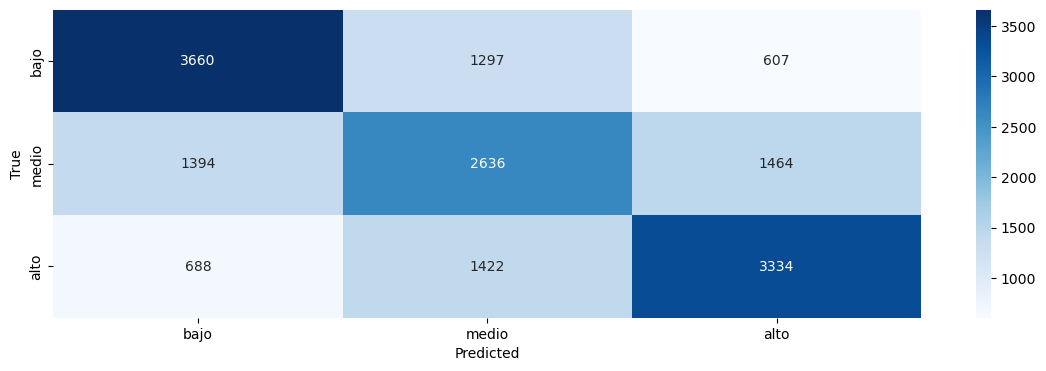

In [133]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

EXPLICAR MATRIZ

### Optimización de Hiperparámetros

Variamos la cantidad de vecinos (K)

In [134]:
neighbors = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 200,5) # vecinos desde 1 hasta 200 con intervalos de 5

for n in k_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    y_pred_res=y_pred.reshape(16502,1) 
    neighbors.append((n, int((y_test == y_pred_res).sum())))

Ploteamos

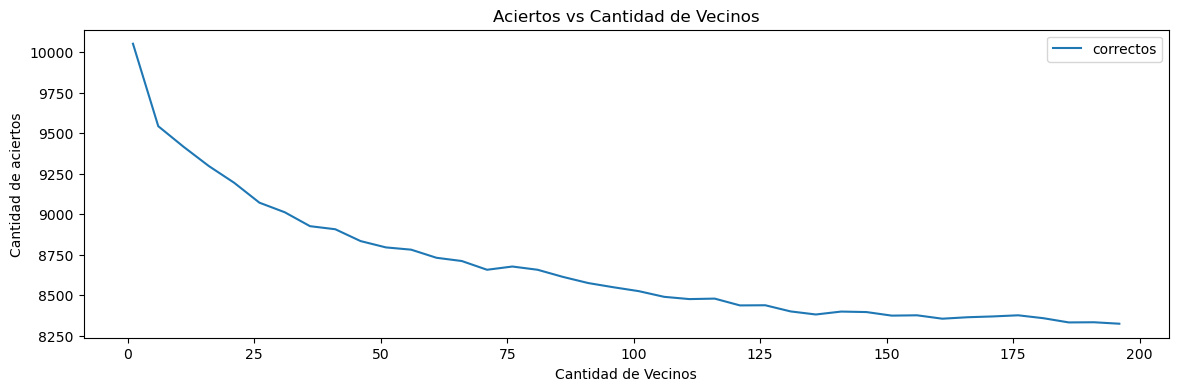

In [135]:
df_metrics = pd.DataFrame(neighbors, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Podemos observar que dentro del intervalo 1 a aproximadamente 40 se encuentra la mayor cantidad de aciertos, variamos la cantidad de vecinos dentro de ese rango. 

In [136]:
neighbors = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 40,1) # vecinos desde 1 hasta 40 con salto de 1

for n in k_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    y_pred_res=y_pred.reshape(16502,1) 
    neighbors.append((n, int((y_test == y_pred_res).sum())))

Ploteamos nuevamente

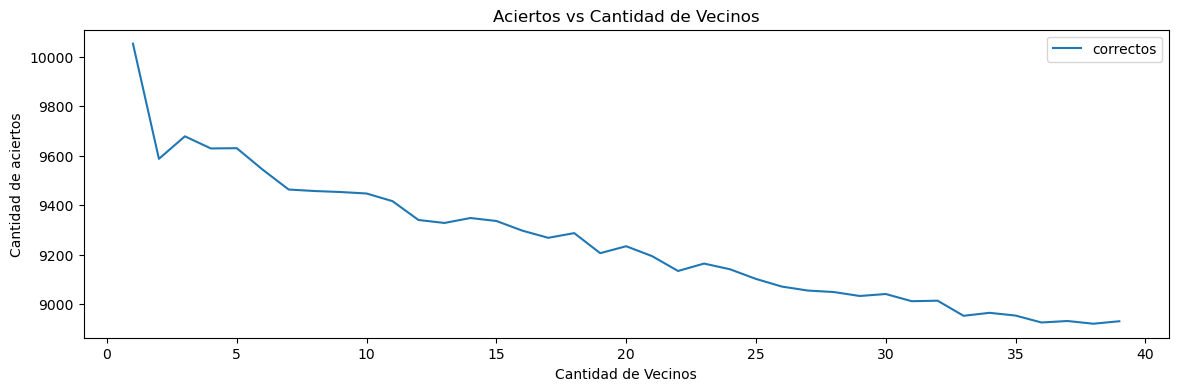

In [137]:
df_metrics = pd.DataFrame(neighbors, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Se observa que a medida que incrementa la cantidad de vecinos, decrece la cantidad de aciertos con algunos picos "en el medio", evaluaremos el rango de 1 a 10 es para ver cual es mejor parametro.

In [138]:
params_grid = { 'n_neighbors':range(1,10,1), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['cityblock',
              'euclidean',
              'haversine',
              'manhattan',]
             }
params_grid

{'n_neighbors': range(1, 10),
 'weights': ['distance', 'uniform'],
 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
 'metric': ['cityblock', 'euclidean', 'haversine', 'manhattan']}

In [139]:
cantidad_tuplas = 1
for param in params_grid:
    cantidad_tuplas *= len(params_grid[param])
cantidad_tuplas

216

Hay 216 posibles juegos de parámetros a probarse.

In [140]:
#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds 
grid_search = grid = RandomizedSearchCV(
                        knn, 
                        params_grid,
                        cv=10,
                        scoring='neg_root_mean_squared_error',
                        n_iter=20,
                        random_state=2)

'''grid_search = GridSearchCV(
                estimator=knn,
                param_grid=params_grid, 
                cv = 10, 
                n_jobs = -1,
                return_train_score='True'
            )'''

grid_search.fit(x_train, y_train.values.ravel())
grid_search.cv_results_['mean_test_score']

array([-0.82168789, -0.77597459, -0.78084754, -0.79462938, -0.7598181 ,
       -0.78042814, -0.76096837,         nan, -0.80769067, -0.78066968,
       -0.7598181 , -0.80366387, -0.78871438, -0.80127767, -0.77654244,
       -0.82876902, -0.80357806, -0.80366387, -0.80380188, -0.80774955])

Mejores parametros

In [141]:
print(grid_search.best_params_)

{'weights': 'distance', 'n_neighbors': 6, 'metric': 'manhattan', 'algorithm': 'ball_tree'}


Mejor metrica

In [142]:
print(grid_search.best_score_)

-0.7598180953182688


### Evaluación de la performance con los mejores hiperparametros

In [143]:
#Mejor estimador
best_knn=grid_search.best_estimator_

#Entrenamos el modelo
best_knn.fit(x_train, y_train)

#Predicción sobre test
y_pred = best_knn.predict(x_test)

# hacemos reshape al array para que tenga dimension 1
y_pred_res=y_pred.reshape(16502 ,1) 

print('Predicciones correctas: ', np.sum(y_test == y_pred_res))
print('Total: ', len(y_test))

Predicciones correctas:  tipo_precio    10273
dtype: int64
Total:  16502


Obtenemos XXXXX aciertos sobre un conjunto de evaluacion de XXXXX elementos, XXXXX% de las veces evaluó correctamente. Obtuvimos solamente XXXXX nuevos aciertos.

Matriz de confusión

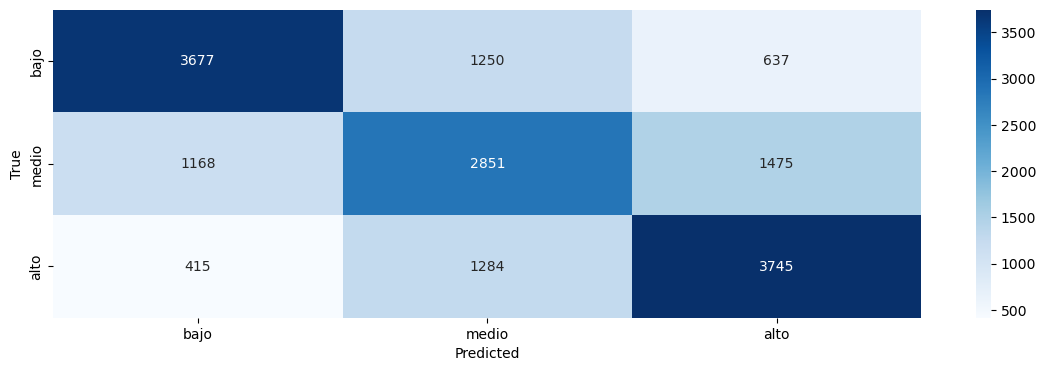

In [144]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

EXPLICAR MATRIZ

### Entrenamiento con PCA

#### Prueba con el modelo sin optimización

In [145]:
df_KNN_pca=df_EyP_pca.copy()
df_KNN_pca

cp_1      cp_2      cp_3      cp_4 tipo_precio
0      1.556266  0.432148 -0.586286 -0.213456        bajo
1     -0.372211 -2.599268  0.381981 -0.307960        bajo
2      0.582906 -2.437438  0.248848 -1.054935        bajo
3      0.691587 -1.100500  0.157895 -0.086541        bajo
4      0.545185 -1.442169 -0.423376 -0.146224       medio
...         ...       ...       ...       ...         ...
82493  1.185426  0.557137 -1.437606 -0.382902        alto
82494 -0.199769  0.186872 -1.307643 -0.035279        alto
82495 -1.721854  0.235450 -0.919138  0.849220       medio
82496 -1.774380  0.230210 -0.919088  0.780698        alto
82497 -0.766844 -1.156733  1.347941  0.508242       medio

[82498 rows x 5 columns]

In [146]:
df_KNN_pca['tipo_precio'] = df_KNN_pca['tipo_precio'].map({'bajo':0,'medio':1,'alto':2},na_action=None)
df_KNN_pca['tipo_precio'].astype('int64')

0        0
1        0
2        0
3        0
4        1
        ..
82493    2
82494    2
82495    1
82496    2
82497    1
Name: tipo_precio, Length: 82498, dtype: int64

In [147]:
df_KNN_pca.head()

cp_1      cp_2      cp_3      cp_4 tipo_precio
0  1.556266  0.432148 -0.586286 -0.213456           0
1 -0.372211 -2.599268  0.381981 -0.307960           0
2  0.582906 -2.437438  0.248848 -1.054935           0
3  0.691587 -1.100500  0.157895 -0.086541           0
4  0.545185 -1.442169 -0.423376 -0.146224           1

In [148]:
# Seleccione variable para predecir
x = df_KNN_pca.drop(["tipo_precio"], axis=1)
y = df_KNN_pca[['tipo_precio']]

#Separacion Train/test  (80/20) según lo pedido
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=2)

In [149]:
#Creamos el modelo
knn = KNeighborsClassifier()

#Miramos los parámetros por defecto
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [150]:
#Entrenamos el modelo
knn.fit(x_train, y_train)

#Predicción sobre test
y_pred = knn.predict(x_test)

# hacemos reshape al array para que tenga dimension 1
y_pred_res=y_pred.reshape(16500,1) 

print('Predicciones correctas: ', np.sum(y_test == y_pred_res))
print('Total: ', len(y_test))

Predicciones correctas:  tipo_precio    6696
dtype: int64
Total:  16500


Obtenemos 7232 aciertos sobre un conjunto de evaluacion de 16529 elementos, 43,8% de las veces evaluó correctamente, hay una perdida significativa de porcentaje de aciertos.

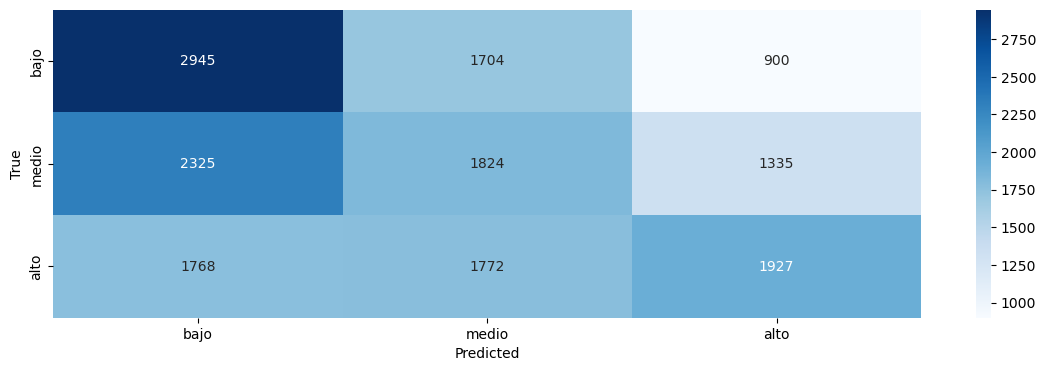

In [151]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

EXPLICAR MATRIZ

#### Optimización de Hiperparámetros

Variamos la cantidad de vecinos (K)

In [152]:
neighbors = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1, 200,5) # vecinos desde 1 hasta 200 con intervalos de 5

for n in k_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    y_pred_res=y_pred.reshape(16500,1) 
    neighbors.append((n, int((y_test == y_pred_res).sum())))

Ploteamos

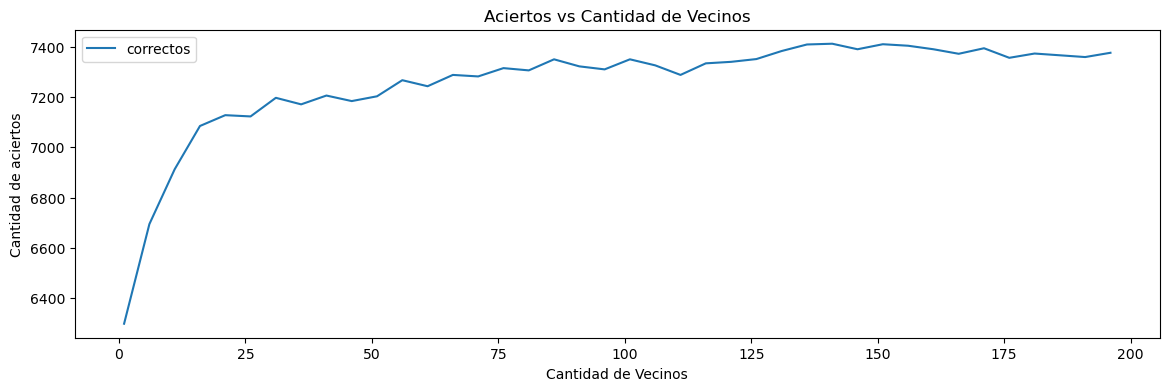

In [153]:
df_metrics = pd.DataFrame(neighbors, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Podemos observar que esta vez la cantidad de aciertos incrementa a medida que hay mayor cantidad de vecinos, variamos la cantidad de vecinos entre 50 y 125.

In [154]:
neighbors = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(50, 125,1) # vecinos desde 50 hasta 125 con salto de 1

for n in k_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    y_pred_res=y_pred.reshape(16500,1) 
    neighbors.append((n, int((y_test == y_pred_res).sum())))

Ploteamos nuevamente

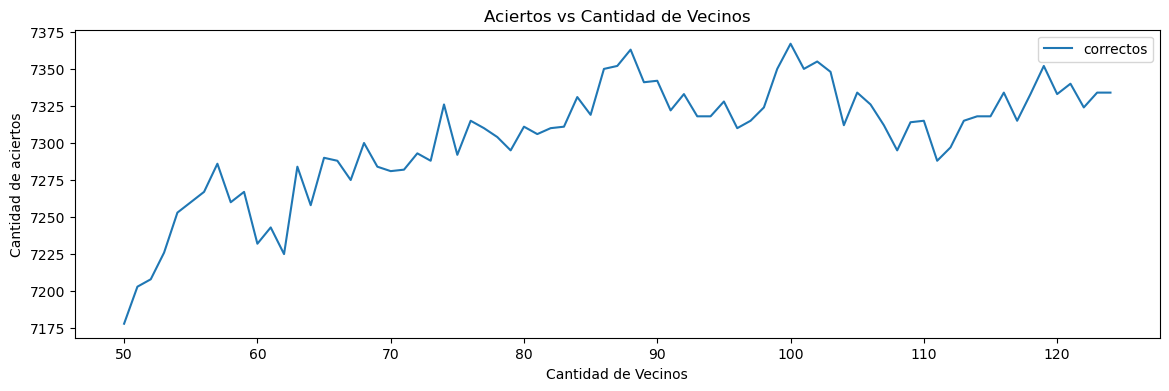

In [155]:
df_metrics = pd.DataFrame(neighbors, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Evaluaremos el rango de 100 a 125, donde el grafico aparenta tener mayor ganancia de aciertos.

In [156]:
params_grid = { 'n_neighbors':range(100,125,1), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['cityblock',
              'euclidean',
              'manhattan',]
             }
params_grid

{'n_neighbors': range(100, 125),
 'weights': ['distance', 'uniform'],
 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
 'metric': ['cityblock', 'euclidean', 'manhattan']}

In [157]:
#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds 
grid_search = grid = RandomizedSearchCV(
                        knn, 
                        params_grid,
                        cv=10,
                        scoring='neg_root_mean_squared_error',
                        n_iter=20,
                        random_state=2)

'''grid_search = GridSearchCV(
                estimator=knn,
                param_grid=params_grid, 
                cv = 10, 
                n_jobs = -1,
                return_train_score='True'
            )'''

grid_search.fit(x_train, y_train.values.ravel())
grid_search.cv_results_['mean_test_score']

array([-1.02249068, -1.02114395, -1.02034691, -1.02200683, -1.02168379,
       -1.02149726, -1.02093027, -1.02228466, -1.02454765, -1.0218614 ,
       -1.0249504 , -1.02362396, -1.02392183, -1.0230554 , -1.02084294,
       -1.02325693, -1.02351365, -1.02082098, -1.02338777, -1.02409163])

Mejores parametros

In [158]:
print(grid_search.best_params_)

{'weights': 'distance', 'n_neighbors': 104, 'metric': 'euclidean', 'algorithm': 'brute'}


Mejor metrica

In [159]:
print(grid_search.best_score_)

-1.0203469128698734


#### Evaluación de la performance con los mejores hiperparametros

In [160]:
#Mejor estimador
best_knn=grid_search.best_estimator_

#Entrenamos el modelo
best_knn.fit(x_train, y_train)

#Predicción sobre test
y_pred = best_knn.predict(x_test)

# hacemos reshape al array para que tenga dimension 1
y_pred_res=y_pred.reshape(16500,1) 

print('Predicciones correctas: ', np.sum(y_test == y_pred_res))
print('Total: ', len(y_test))

Predicciones correctas:  tipo_precio    7259
dtype: int64
Total:  16500


Obtenemos 8302 aciertos sobre un conjunto de evaluacion de 16529 elementos, 50,2% de las veces evaluó correctamente. Hubo una mejora notable del 6,6% en cantidad de aciertos, sin embargo no logra alcanzar la efectividad del dataset con dimensiones no reducidas. 

Matriz de Confusión

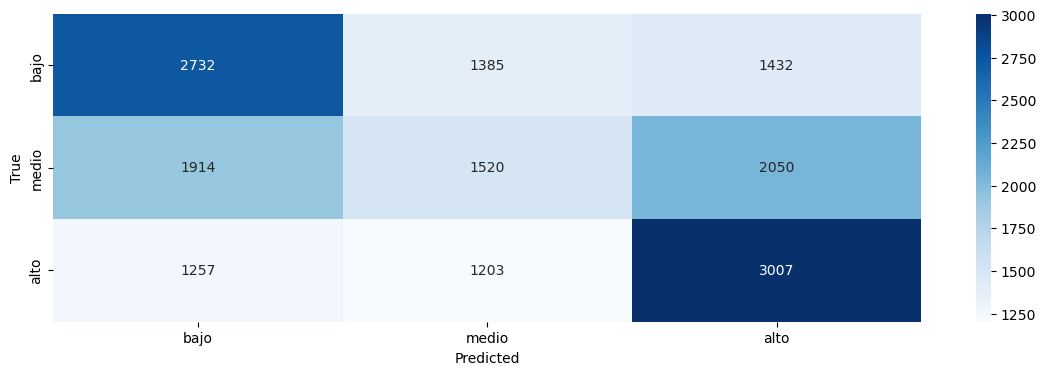

In [161]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['bajo','medio','alto'], 
                     columns = ['bajo','medio','alto'])

sns.heatmap(cm_df, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

EXPLICAR MATRIZ

# Conclusiones

Se pudieron observar como los distintos modelos crean reglas que podemos tomar como las correctas tienden a se de un tipo de precio más elevado, como por ejemplo, el Árbol de decisión se puede ver que los precios son más altos
si el inmobiliario esta cerca de un río o si se encuentran dentro de barrios como 'Puerto Madero'. Pero con el 
tercer modelo elegido no pudimos dar estimaciones correctas acerca de como varían los precios.

Exportamos el dataset para utilización en el tp 2

In [162]:
df_tprecio.to_csv("properati_argentina_2021_filtrado_tprecio.csv")